In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os

from lonboard import Map, ScatterplotLayer
from functions import geo_to_h3, group_by_h3_cell, add_geometry, open_tif
from shapely.geometry import box

from rasterio.plot import plotting_extent
from rasterio.mask import mask
from rasterio.windows import from_bounds
import rasterio
import rasterio.features
from shapely.geometry import Point
from rasterio.transform import rowcol

import geopandas as gpd
from shapely.geometry import mapping, box, Polygon
import numpy as np

import matplotlib.pyplot as plt

In [2]:
raster_data, bounds, crs = open_tif("../data/data_layers/soil_grid/Acrisols.tif")
reduced_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)


POE_TOT = gpd.read_file("../data/saved_df/POE_PROV.gpkg", layer="vue_pe_espece_tot")
POE_TOT['geometry'] = POE_TOT.geometry.to_crs(epsg=4326)
POE_TOT['geometry'] = POE_TOT.geometry.centroid

# Create a bounding box from the reduced_extent
bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

# Filter POE_TOT to only keep geometries within the bounding box
POE_TOT_reduced = POE_TOT[POE_TOT.geometry.within(bounding_box)]

/tmp/ipykernel_27846/3882448820.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  POE_TOT['geometry'] = POE_TOT.geometry.centroid


the landuse file is too big to work with so i first cropped it to the area of interest
and then i  desampled it by a factor of 0.5

In [ ]:

# #clip a raster to the bounding box
# with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif") as src:
#     out_image, out_transform = mask(src, [mapping(bounding_box)], crop=True)
#     out_meta = src.meta.copy()
#     #save the clipped raster
#     out_meta.update({
#         "driver": "GTiff",
#         "height": out_image.shape[1],
#         "width": out_image.shape[2],
#         "transform": out_transform
#     })
#     with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif", "w", **out_meta) as dest:
#         dest.write(out_image)

<Axes: xlabel='espece'>

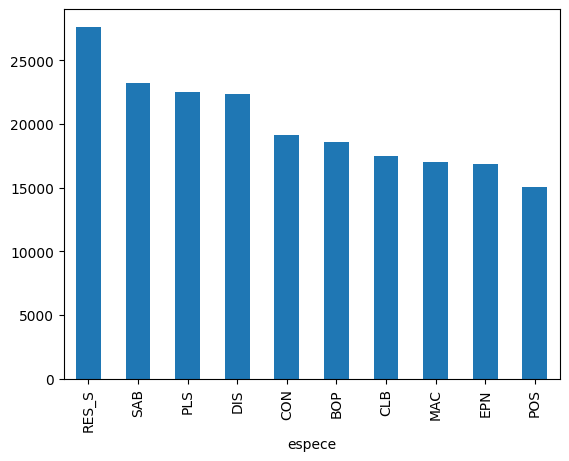

In [ ]:
#plot distribution ofPOE_TOT by 'espece'
#POE_TOT['espece'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar')

### Extract location data from raster

In [5]:
def add_raster_values_to_geodf(raster_path, geodf, column_name='raster_value'):
    """
    Extract raster values at GeoDataFrame point geometries and add as a new column.
    
    Parameters:
    ----------
    raster_path : str
        Path to the raster file (.tif, etc)
    geodf : geopandas.GeoDataFrame
        GeoDataFrame with Point geometries
    column_name : str, optional
        Name for the new column(s) with raster values
        
    Returns:
    -------
    geopandas.GeoDataFrame
        Input GeoDataFrame with added raster value column(s)
    """
    # Open the raster
    with rasterio.open(raster_path) as src:
        
        # # Transform the GeoDataFrame to the raster's CRS if needed
        # if geodf.crs != src.crs:
        #     print(f"Transforming GeoDataFrame CRS from {geodf.crs} to {src.crs}.")
        #     geodf.to_crs(src.crs)
        
        # Check if we have a multi-band raster
        multi_band = src.count > 1
        
        # Create columns for each band if multi-band raster
        if multi_band:
            print("Multi-band raster detected.")
            column_names = [f"{column_name}_{i+1}" for i in range(src.count)]
            for col in column_names:
                geodf[col] = np.nan
        else:
            geodf[column_name] = np.nan
        
        # Extract the coordinates from the geometries
        for idx, geom in geodf.iterrows():
            # Check if the geometry is a Point or Polygon
            if geom.geometry.geom_type == 'Point':
                x, y = geom.geometry.x, geom.geometry.y
            elif geom.geometry.geom_type == 'Polygon':
                centroid = geom.geometry.centroid
                x, y = centroid.x, centroid.y
            else:
                print(f"Unsupported geometry type: {geom.geometry.geom_type}")
                continue
            
            # Convert coordinates to pixel indices
            row, col = rowcol(src.transform, x, y)
            
            # Check if the point is within the raster bounds
            if 0 <= row < src.height and 0 <= col < src.width:
                # For multi-band raster
                if multi_band:
                    for band in range(src.count):
                        value = src.read(band+1, window=((row, row+1), (col, col+1)))[0, 0]
                        # Handle nodata values
                        if value == src.nodata:
                            value = np.nan
                        geodf.at[idx, column_names[band]] = value
                # For single-band raster
                else:
                    value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                    # Handle nodata values
                    if value == src.nodata:
                        value = np.nan
                    geodf.at[idx, column_name] = value
        
        return geodf

In [ ]:
# import os

# folder_path = '../data/data_layers'
# file_paths = []
# file_names = []
# for root, dirs, files in os.walk(folder_path):
#     for file in files:
#         full_path = os.path.join(root, file)
#         file_paths.append(full_path)
#         file_names.append(os.path.splitext(file)[0])
#take the first elem different elem of no_poe and create a df of 10 unique of those elem
# no_poe = POE_TOT['no_viree'].unique()
# unique_no_viree_df = POE_TOT_reduced.drop_duplicates(subset='no_viree').head(10)


# for i, file_path in enumerate(file_paths):
#     print(f"Processing {file_path}")
#     col_name = file_names[i]
#     add_raster_values_to_geodf(
#         raster_path=file_path,
#         geodf=POE_TOT,
#         column_name=col_name
#     )
#save to csv
# unique_no_viree_df.to_csv('POE_TOT_raster_values.csv', index=False)

Had issues with the landuse data since it was not in the same projection as the other data. I used the `gdalwarp` command to reproject the landuse data to match the other data. The command is as follows:

```
gdalwarp -s_srs EPSG:32198 -t_srs EPSG:4326 -co "COMPRESS=LZW" utilisation_territoire_2020.tif output_raster.tif 
```

### Extract h3 hex from location

In [3]:
#generate h3 index
POE_TOT_reduced['h3_index'] = POE_TOT_reduced.geometry.apply(lambda point: geo_to_h3(point.y, point.x, 12))

#group by h3 index and species
processed_species = group_by_h3_cell(POE_TOT_reduced, h3_col='h3_index', species_col='espece')

# #add the hex geometry for each h3_cell
processed_species = gpd.GeoDataFrame(
    processed_species,
    geometry=processed_species.apply(lambda x: add_geometry({'h3_cell': x['h3_index']}), axis=1),
    crs="EPSG:4326"
)

raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band of the raster
    my_extent = rasterio.plot.plotting_extent(src)  # Get the extent of the raster
    print(my_extent)

    # Create a bounding box from the extent
    bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])

    # Filter rows where geometry is completely inside the bounding box
    processed_species = processed_species[processed_species.geometry.within(bounding_box)]

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


157702
(-75.665588, -70.894775, 45.26328900000001, 47.31834500000001)


In [4]:
def get_clipped_bounds(out_image, out_transform):
    height, width = out_image.shape[-2:]
    left, top = rasterio.transform.xy(out_transform, 0, 0)
    right, bottom = rasterio.transform.xy(out_transform, height, width)
    return (left, bottom, right, top) 

def extract_raster_values_for_h3(geometry, raster_path):
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        h3_geometry = gpd.GeoSeries([geometry], crs="EPSG:4326")
        h3_geometry = h3_geometry.to_crs(src.crs)
        
        # Get raster resolution
        res_x, res_y = src.res
        
        # Check if hexagon is smaller than raster resolution
        hex_area = h3_geometry[0].area
        pixel_area = abs(res_x * res_y)
        
        if hex_area < pixel_area:
            # Hex is smaller than a pixel - use point sampling instead
            centroid = h3_geometry[0].centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                # Read single value - fixed parenthesis issue here
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                # Create a 1x1 array with the value
                out_image = np.array([[[value]]])
                # Create a transform for this single point
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
                clipped_bounds = (left, bottom, right, top)
                return out_image, clipped_bounds
            except (IndexError, ValueError):
                raise ValueError("Hexagon centroid is outside raster bounds or could not be sampled")
        
        # Convert to GeoJSON
        geometry_proj = mapping(h3_geometry[0])
        
        # Create a bounding box from the raster bounds
        raster_bounds = box(*src.bounds)
        
        # Check overlap
        if not raster_bounds.intersects(h3_geometry[0]):
            raise ValueError("Geometry does not overlap the raster bounds.")
        
        try:
            # Mask the raster
            out_image, out_transform = mask(
                src, 
                [geometry_proj], 
                crop=True,
                filled=True,
                #nodata=np.nan
                nodata = src.nodata
            )
            
            # Check if we got all NaN values (might still happen)
            if np.all(np.isnan(out_image)):
                # Fall back to point sampling at centroid
                centroid = h3_geometry[0].centroid
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row+1, col+1)
                out_transform = src.window_transform(((row, row+1), (col, col+1)))
            
            clipped_bounds = get_clipped_bounds(out_image, out_transform)
            return out_image, clipped_bounds
            
        except ValueError as e:
            if "Input shapes do not overlap raster" in str(e):
                raise ValueError("Geometry does not overlap the raster bounds.")
            raise

### Cutting data layers into hexagons

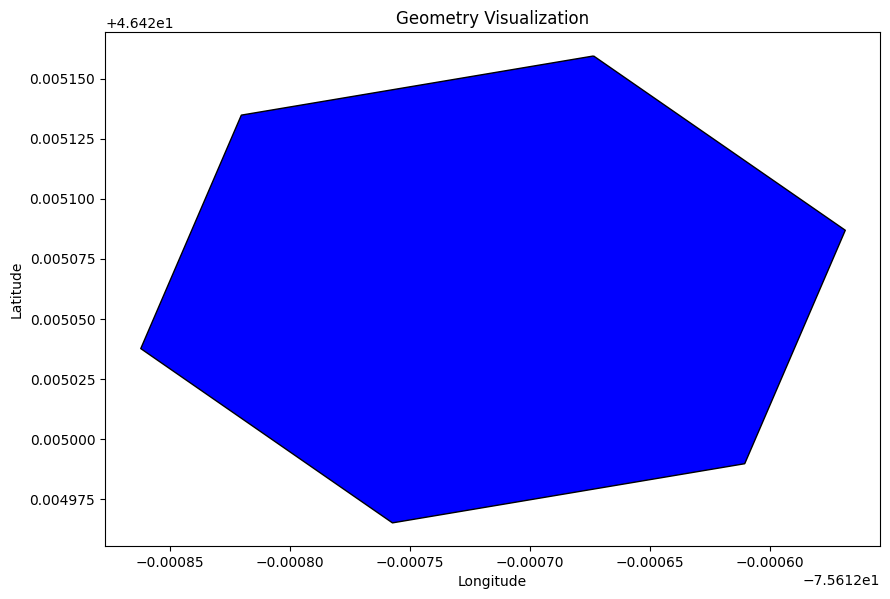

In [27]:
import matplotlib.pyplot as plt

# Select a row from processed_species
row_geometry = processed_species.iloc[0]['geometry']

# Plot the geometry
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries(row_geometry).plot(ax=ax, color='blue', edgecolor='black')
plt.title('Geometry Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

(np.float64(-75.665588), np.float64(-70.89892133333333), np.float64(45.26001166666668), np.float64(47.31834500000001))


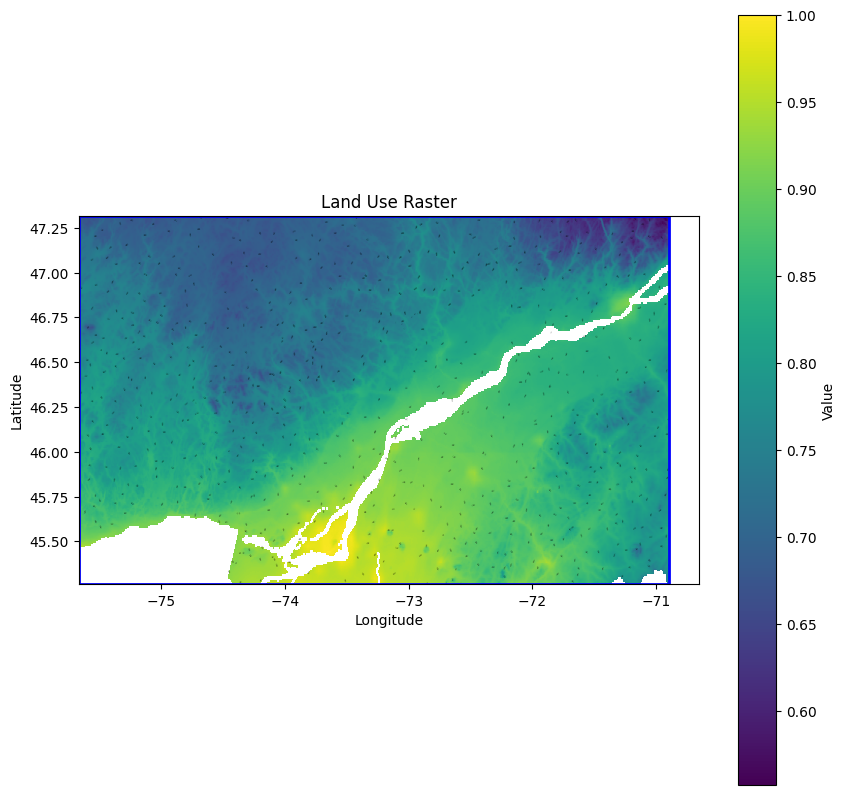

In [ ]:
geom = processed_species['geometry']

# Open the raster file
#raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
#raster_path = "../data/data_layers/soil_grid/Solonetz.tif"
raster_path = "../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif"
with rasterio.open(raster_path) as src:
    window = from_bounds(left = reduced_extent[0], bottom = reduced_extent[2], right=reduced_extent[1], top=reduced_extent[3], transform=src.transform)
    # Read the data within the window
    raster_data = src.read(1, window=window)  # Read the first band of the raster
    window_transform = src.window_transform(window)
    extent = rasterio.plot.plotting_extent(raster_data, window_transform)  # Get the extent of the raster
    print(extent)

# Plot the raster data
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap='viridis', extent=extent)
# Plot the geometry on top of the raster
# Ensure geom contains individual geometries
if isinstance(geom, gpd.GeoSeries):
    geom_to_plot = geom
else:
    geom_to_plot = gpd.GeoSeries(geom)

# Plot the geometry on top of the raster
geom_to_plot.plot(ax=plt.gca(), color='red', edgecolor='black', alpha=0.5)

# Plot the bounding box on the figure
bounding_box = box(reduced_extent[0], reduced_extent[2], reduced_extent[1], reduced_extent[3])
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")
bounding_box_gdf.boundary.plot(ax=plt.gca(), color='blue', linewidth=2, label='Bounding Box')

# Add a colorbar
plt.colorbar(label='Value')
plt.title('Land Use Raster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

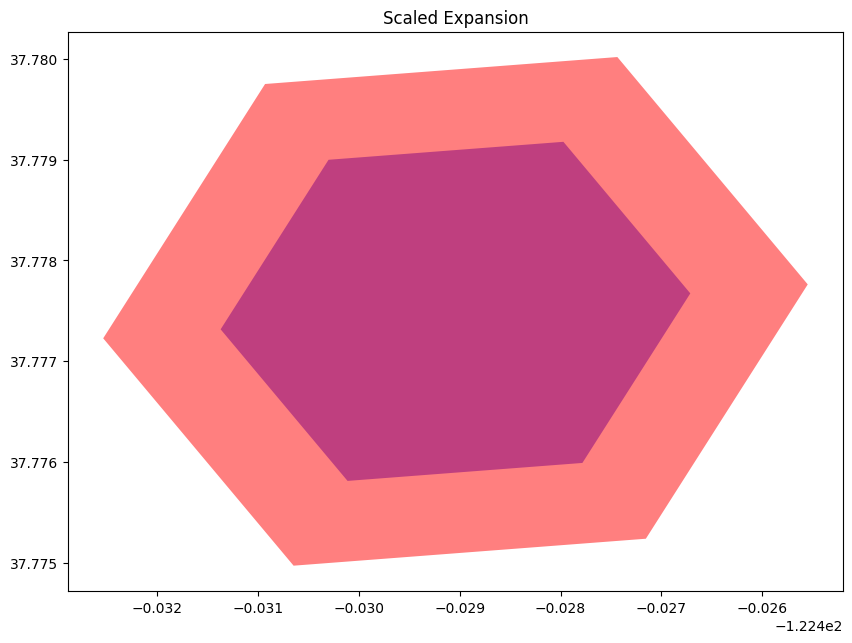

In [5]:
import matplotlib.pyplot as plt

import h3
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.affinity import scale

def expand_hexagon(h3_index, expansion_factor):
    """
    Uniformly expands a hexagon by scaling from its centroid
    
    Args:
        h3_index: H3 hexagon index
        expansion_factor: Multiplier for expansion (1.1 = 10% larger)
    
    Returns:
        Expanded Polygon geometry
    """
    # Get hexagon boundary as list of (lat,lng) points
    hex_boundary = h3.cell_to_boundary(h3_index)

    flipped = tuple(coord[::-1] for coord in hex_boundary)
    
    # Create Shapely polygon
    hex_poly = Polygon(flipped)
    
    # Scale the polygon from its centroid
    expanded_poly = scale(hex_poly, 
                         xfact=expansion_factor, 
                         yfact=expansion_factor, 
                         origin='centroid')
    
    return expanded_poly

def plot_hexagons(original, expanded, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    gpd.GeoSeries([original]).plot(ax=ax, color='blue', alpha=0.5)
    gpd.GeoSeries([expanded]).plot(ax=ax, color='red', alpha=0.5)
    plt.title(title)
    plt.show()

# Example visualization
hex_id = '89283082837ffff'
original_hex = h3.cell_to_boundary(hex_id)
original_hex = tuple(coord[::-1] for coord in original_hex)
# Create Shapely polygon
original_hex = Polygon(original_hex)

# Compare different methods
expanded_scale = expand_hexagon(hex_id, 1.5)

plot_hexagons(original_hex, expanded_scale, "Scaled Expansion")

In [13]:
def vis_one_band_raster(out_images, clipped_bounds, side_by_side=False):
    """
    Visualize multiple single-band raster images.

    Parameters:
    ----------
    out_images : list of numpy.ndarray
        List of raster images to visualize.
    clipped_bounds : tuple
        Tuple containing the bounds (left, bottom, right, top) for the extent.
    side_by_side : bool, optional
        If True, plots the images side by side. Otherwise, overlays them.
    """
    left, bottom, right, top = clipped_bounds
    extent = (left, right, bottom, top)
    
    fig, axes = plt.subplots(1, len(out_images), figsize=(15, 10))
    for i, out_image in enumerate(out_images):
        ax = axes[i] if len(out_images) > 1 else axes
        im = ax.imshow(
            out_image, 
            cmap='viridis', 
            extent=extent
        )
        ax.set_title(f'Raster {i+1}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        #cbar = plt.colorbar(im, ax=ax, orientation='vertical')
        #cbar.set_label('Normalized Value')

    plt.show()
# Define a function to normalize each band using percentiles
def normalize_band(band, min_percentile=2, max_percentile=98):
    if band.size == 0:
        raise ValueError("Band is empty")
    vmin = np.percentile(band, min_percentile)  # Lower bound
    vmax = np.percentile(band, max_percentile)  # Upper bound
    band = np.clip(band, vmin, vmax)  # Clip values outside percentile range
    return (band - vmin) / (vmax - vmin)  # Normalize to [0, 1]

def vis_rgb_raster(out_image, clipped_bounds):
    # Access the elements of the tuple directly
    left, bottom, right, top = clipped_bounds
    plt.figure(figsize=(10, 10))
    extent = (left, right, bottom, top)
    
    rgb_image = np.stack([
            normalize_band(out_image[0]),  # Normalize Red
            normalize_band(out_image[1]),  # Normalize Green
            normalize_band(out_image[2])   # Normalize Blue
    ], axis=-1)
    plt.imshow(rgb_image, extent=extent)
    plt.title('RGB Composite')
    

POLYGON ((-74.89547259844491 47.09130063636324, -74.89562190735727 47.09127680950957, -74.89566602773687 47.091179322527566, -74.89556083971694 47.09110566254272, -74.8954115313614 47.091129489289074, -74.89536741046898 47.09122697612759, -74.89547259844491 47.09130063636324))


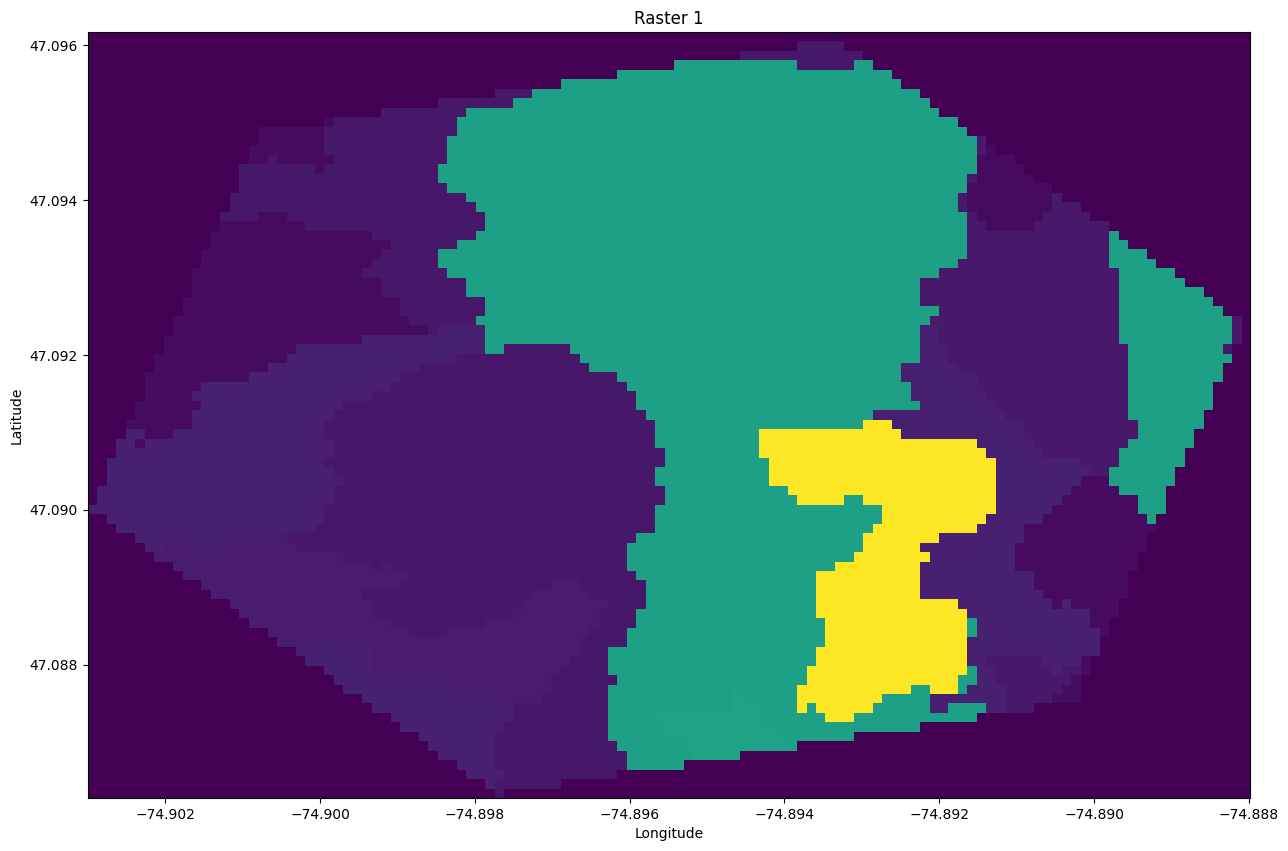

In [83]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[1040]
h3_cell = processed_species['h3_index'].values[1040]
expanded_geom = expand_hexagon(h3_cell, 50)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
#vis_rgb_raster(out_image, clipped_bounds)

In [84]:
results = extract_raster_values_for_multiple_h3_chunked(
    geometries=expanded_geom,
    raster_path="../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif",
    #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
    chunk_size_mb=5000  # Adjust based on your memory constraints
)

Raster size 72692.86 MB exceeds chunk size 5000 MB. Using chunked processing.


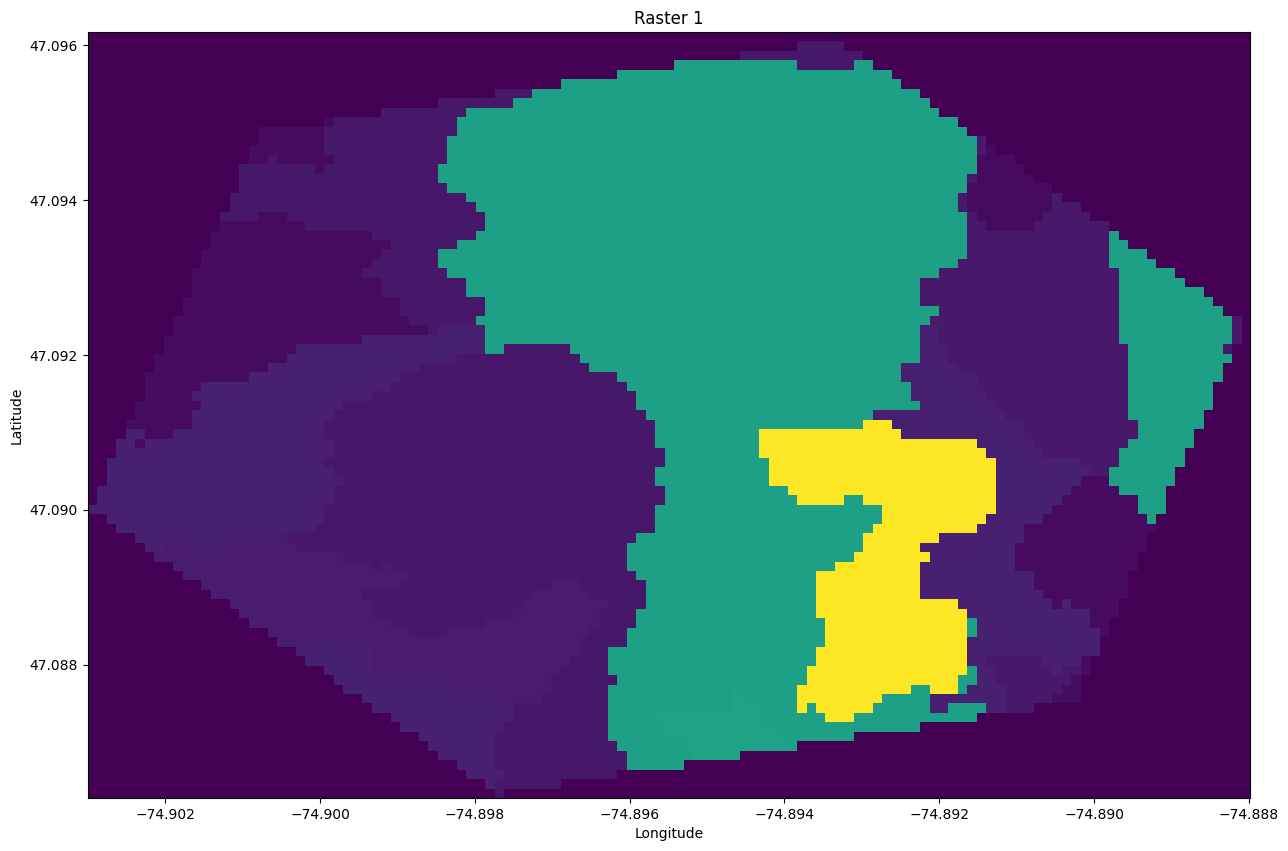

In [85]:
output, bounds = results[0]  # Assuming results is a list of tuples

vis_one_band_raster(output, bounds)

In [19]:
geom = processed_species.iloc[1000]
add_raster_values_to_geodf(
        raster_path="../data/data_layers/worldClim/clipped_wc2.1_30s_bio_1.tif",
        geodf=processed_species[1000:1001],
        column_name=col_name
)

NameError: name 'col_name' is not defined

In [380]:
# Calculate zonal statistics
from rasterstats import zonal_stats

stats = ['min', 'max', 'mean']
proc_spec = processed_species.copy()
z_stats = zonal_stats(
                vectors=expand_hexagon(proc_spec['h3_index'].values[1000:1001][0], 50),
                raster="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
                stats=stats,
                #layer=1,
                all_touched=False, 
                )

### Extracting zonal stats from hexagons


In [20]:
#read csv
import pandas as pd
land_use_labels = pd.read_csv('../data/misc/utilisation_territoire_labels.csv')

In [21]:
category_map = dict(zip(land_use_labels['CODE_UT'].astype(float), land_use_labels['Classe détaillée']))

In [274]:
proc_spec = processed_species.copy()
geom = proc_spec['geometry'].values[0:10]

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats


# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=False,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13.csv', index=False)

In [ ]:
# # Calculate zonal statistics
# from rasterstats import zonal_stats

# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=False,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

In [170]:
from rasterstats import zonal_stats
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import time

def get_centroid_value(geometry, raster_path):
    """Get raster value at geometry's centroid"""
    with rasterio.open(raster_path) as src:
        # Reproject geometry to match raster CRS
        geom = gpd.GeoSeries([geometry], crs="EPSG:4326").to_crs(src.crs)[0]
        centroid = geom.centroid
        
        try:
            row, col = src.index(centroid.x, centroid.y)
            value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
            return value
        except (IndexError, ValueError):
            return np.nan
def get_centroid_values(geometries, raster_path):
    """Get raster values at geometries' centroids"""
    with rasterio.open(raster_path) as src:
        # Reproject geometries to match raster CRS
        geom_series = gpd.GeoSeries(geometries, crs="EPSG:4326").to_crs(src.crs)
        
        values = []
        for geom in geom_series:
            centroid = geom.centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row+1), (col, col+1)))[0, 0]
                values.append(value)
            except (IndexError, ValueError):
                values.append(np.nan)
        return values

def should_use_centroid(geometries, raster_path, sample_size=5):
    """Check if we should use centroid sampling for this raster"""
    with rasterio.open(raster_path) as src:
        # Get raster resolution
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)
        
        # Check sample of geometries
        sample_idx = np.random.choice(len(geometries), min(sample_size, len(geometries)), replace=False)
        sample_geoms = gpd.GeoSeries([geometries[i] for i in sample_idx], crs="EPSG:4326").to_crs(src.crs)
        
        # Count how many are smaller than a pixel
        small_count = sum(1 for geom in sample_geoms if geom.area < pixel_area)
        return small_count / len(sample_geoms) > 0.8  # Use centroid if >80% are small

# Main processing function
def process_rasters(proc_spec, file_paths, file_names, category_map=None):
    # Prepare results storage
    continuous_data = {}
    categorical_data = {'h3_index': proc_spec['h3_index'].values}
    
    for i, file_path in enumerate(file_paths):
        col_name = file_names[i]
        #print(f"Processing {file_path}")
        
        # Special handling for categorical raster
        if 'utilisation_territoire' in file_path:
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling for categorical data
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                categorical_data['landuse_value'] = values
                #categorical_data['landuse_method'] = ['centroid'] * len(values)
                
                # Map category numbers to names
                if category_map:
                    categorical_data['landuse_category'] = [
                        category_map.get(int(val), 'Unknown') if not np.isnan(val) else 'Unknown' 
                        for val in values
                    ]

            else:
                # Proper categorical zonal stats
                start = time.time()
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    categorical=True,
                    category_map=category_map,
                    all_touched=False
                )
                end = time.time()
                print(f"Zonal stats took {end - start:.2f} seconds")
                start = time.time()
                # Flatten categorical results
                for idx, stats in enumerate(z_stats):
                    for cat, count in stats.items():
                        if cat != 'h3_index':
                            col = f'landuse_{cat}'
                            if col not in categorical_data:
                                categorical_data[col] = [0] * len(z_stats)
                            categorical_data[col][idx] = count
                end = time.time()
                print(f"Flattening took {end - start:.2f} seconds")
                #categorical_data['landuse_method'] = ['zonal_stats'] * len(z_stats)
        else:
            # Continuous raster processing
            if should_use_centroid(proc_spec['geometry'].values, file_path):
                # Centroid sampling
                #values = [get_centroid_value(geom, file_path) for geom in proc_spec['geometry'].values]
                values = get_centroid_values(proc_spec['geometry'].values, file_path)
                continuous_data[f'{col_name}_value'] = values
                #continuous_data[f'{col_name}_method'] = ['centroid'] * len(values)
            else:
                # Zonal stats
                z_stats = zonal_stats(
                    vectors=proc_spec['geometry'].values,
                    raster=file_path,
                    stats=['mean', 'min', 'max'],
                    all_touched=False
                )
                
                continuous_data[f'{col_name}_value'] = [s.get('mean', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_min'] = [s.get('min', np.nan) for s in z_stats]
                continuous_data[f'{col_name}_max'] = [s.get('max', np.nan) for s in z_stats]
    
    # Create final DataFrames
    continuous_df = gpd.GeoDataFrame(
        {**continuous_data, 'geometry': proc_spec['geometry'].values},
        crs="EPSG:4326"
    )
    continuous_df['h3_index'] = proc_spec['h3_index'].values
    
    categorical_df = pd.DataFrame(categorical_data)
    categorical_df['h3_index'] = proc_spec['h3_index'].values
    
    return continuous_df, categorical_df

In [171]:
# Execute processing
continuous_results, categorical_results = process_rasters(
    proc_spec=processed_species.copy(),
    file_paths=file_paths,  # Include all file paths
    file_names=file_names,
    category_map=category_map
)

# # Save results
# continuous_results.to_csv('continuous_zonal_stats_res_12.csv', index=False)
# categorical_results.to_csv('cat_zonal_stats_res_12.csv', index=False)

Zonal stats took 14.83 seconds
Flattening took 0.00 seconds


In [165]:
#add h3_index column to continuous_results
continuous_results

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry,h3_index
0,0,1,0,1,8,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61267 46.42516, -75.61282 46.425...",8c2b80005b121ff
1,0,1,0,1,10,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.60915 46.42512, -75.6093 46.4250...",8c2b80005b233ff
2,0,0,0,1,9,0,0,0,0,0,...,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61594 46.42515, -75.61609 46.425...",8c2b80005b959ff
3,0,0,0,1,12,1,0,0,0,0,...,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57214 46.48563, -75.57229 46.485...",8c2b800241617ff
4,0,1,0,1,17,1,0,0,0,0,...,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57171 46.48065, -75.57185 46.480...",8c2b800243209ff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,0,0,0,0,14,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63106 47.11539, -72.63121 47.115...",8c2baedb2c0b9ff
4615,0,0,0,0,16,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.62938 47.11293, -72.62953 47.112...",8c2baedb2c4a5ff
4616,0,0,0,0,14,0,0,0,0,0,...,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63029 47.11442, -72.63045 47.114...",8c2baedb2c50bff
4617,0,0,0,0,11,0,0,0,0,1,...,273,0.803079,0.340909,0.750928,0.588367,0.853480,0.887770,0.370614,"POLYGON ((-72.63361 47.11916, -72.63376 47.119...",8c2baedb2d817ff


In [420]:
def post_process_continuous(continuous_df):
    """
    Simplifies continuous results DataFrame by removing redundant columns when 
    min, max and value (mean) are identical for the same raster.
    
    Parameters:
    -----------
    continuous_df : GeoDataFrame
        The continuous results DataFrame with columns in format:
        {raster_name}_value, {raster_name}_min, {raster_name}_max, etc.
    
    Returns:
    --------
    GeoDataFrame
        Simplified DataFrame with redundant columns removed
    """
    # Make a copy to avoid modifying the original
    df = continuous_df.copy()
    
    # Identify all unique raster base names
    columns = [col for col in df.columns if not col in ['geometry', 'h3_index']]
    raster_names = list(set([col.split('_')[0] for col in columns if '_value' in col or '_min' in col or '_max' in col]))
    
    columns_to_drop = []
    
    for raster in raster_names:
        value_col = f"{raster}_value"
        min_col = f"{raster}_min"
        max_col = f"{raster}_max"
        
        # Check if all three columns exist
        if all(col in df.columns for col in [value_col, min_col, max_col]):
            
            # Check if all values are identical across the three columns
            if (df[value_col] == df[min_col]).all() and (df[value_col] == df[max_col]).all():
                print(f"All values are identical for {raster}. Dropping min and max columns.")
                # Mark min and max columns for removal
                columns_to_drop.extend([min_col, max_col])
                
                # Update method column if exists
                method_col = f"{raster}_method"
                if method_col in df.columns:
                    df[method_col] = df[method_col].replace({'zonal_stats': 'single_value'})
    
    # Drop redundant columns
    df = df.drop(columns=columns_to_drop)
    
    return df
# Usage example:
simplified_df = post_process_continuous(continuous_results)
#simplified_df.to_csv('simplified_continuous_stats.csv', index=False)

In [455]:
simplified_df

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,clipped_wc2.1_30s_bio_14_value,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry
0,0,1,0,1,8,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61282 46.4251, -75.61287 46.4250..."
1,0,1,0,1,10,0,0,0,0,0,...,0.510417,289,0.824960,0.350649,0.787039,0.535421,0.882784,0.901359,0.384211,"POLYGON ((-75.60914 46.42501, -75.60919 46.424..."
2,0,0,0,1,9,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61599 46.42509, -75.61604 46.425..."
3,0,0,0,1,12,1,0,0,0,0,...,0.510417,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57224 46.48562, -75.57229 46.485..."
4,0,1,0,1,17,1,0,0,0,0,...,0.500000,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57165 46.48059, -75.5717 46.4805..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,6,0,0,0,0,0,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01388 47.05253, -75.01393 47.052..."
996,0,0,0,1,9,0,0,0,0,0,...,0.510417,343,0.777958,0.298701,0.720257,0.565996,0.853480,0.840463,0.500000,"POLYGON ((-75.01707 47.05069, -75.01712 47.050..."
997,0,0,0,1,12,0,0,0,0,0,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01234 47.0535, -75.01238 47.0534..."
998,0,0,0,0,15,0,0,0,0,1,...,0.520833,360,0.774716,0.298701,0.716547,0.571216,0.853480,0.838450,0.498246,"POLYGON ((-75.01142 47.05405, -75.01147 47.054..."


#### Extracting zonal stats for regions

From my tests its useless to expand less than 10x since the raster resolution is pretty low

In [174]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


In [176]:
for factor in factors:
    print(f"Processing with factor: {factor}")
    #Execute processing
    proc_spec = processed_species.copy()
    #15x is the minimum size to get zonal stats on gridsoil and satelitte data
    proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, factor))

    continuous_results_x10, categorical_results_x10 = process_rasters(
        proc_spec=proc_spec.copy(),
        file_paths=file_paths,  # Include all file paths
        file_names=file_names,
        category_map=category_map
    )

    # Save results
    continuous_results_x10.to_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv', index=False)
    categorical_results_x10.to_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv', index=False)

Processing with factor: 1.25
Zonal stats took 15.87 seconds
Flattening took 0.00 seconds
Processing with factor: 1.5625
Zonal stats took 17.34 seconds
Flattening took 0.01 seconds
Processing with factor: 1.953125
Zonal stats took 19.35 seconds
Flattening took 0.00 seconds
Processing with factor: 2.44140625
Zonal stats took 21.41 seconds
Flattening took 0.00 seconds
Processing with factor: 3.0517578125
Zonal stats took 24.38 seconds
Flattening took 0.00 seconds
Processing with factor: 3.814697265625
Zonal stats took 27.99 seconds
Flattening took 0.00 seconds
Processing with factor: 4.76837158203125
Zonal stats took 32.38 seconds
Flattening took 0.01 seconds
Processing with factor: 5.9604644775390625
Zonal stats took 37.78 seconds
Flattening took 0.01 seconds
Processing with factor: 7.450580596923828
Zonal stats took 44.45 seconds
Flattening took 0.01 seconds


In [27]:
# Save results
continuous_results_x10.to_csv('continuous_zonal_stats_res_12_x10.csv', index=False)
categorical_results_x10.to_csv('cat_zonal_stats_res_12.csv_x10.csv', index=False)

In [439]:
continuous_results_x10

,Umbrisols_value,Chernozems_value,Cryosols_value,Regosols_value,Gleysols_value,Leptosols_value,Gypsisols_value,Solonchaks_value,Nitisols_value,Arenosols_value,...,clipped_wc2.1_30s_bio_14_value,quebec_clipped_wc2.1_30s_elev_value,clipped_wc2.1_30s_bio_10_value,clipped_wc2.1_30s_bio_6_value,clipped_wc2.1_30s_bio_1_value,clipped_wc2.1_30s_bio_12_value,clipped_wc2.1_30s_bio_5_value,clipped_wc2.1_30s_bio_8_value,clipped_wc2.1_30s_bio_9_value,geometry
0,0,1,0,1,8,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61284 46.42544, -75.61332 46.425..."
1,0,1,0,1,10,0,0,0,0,0,...,0.510417,289,0.824960,0.350649,0.787039,0.535421,0.882784,0.901359,0.384211,"POLYGON ((-75.60917 46.42535, -75.60965 46.425..."
2,0,0,0,1,9,0,0,0,0,0,...,0.510417,299,0.820097,0.350649,0.783577,0.540641,0.879121,0.898339,0.383772,"POLYGON ((-75.61602 46.42544, -75.61649 46.425..."
3,0,0,0,1,12,1,0,0,0,0,...,0.510417,310,0.820097,0.337662,0.774425,0.546607,0.882784,0.898339,0.374561,"POLYGON ((-75.57227 46.48597, -75.57275 46.485..."
4,0,1,0,1,17,1,0,0,0,0,...,0.500000,271,0.824149,0.344156,0.784566,0.536913,0.882784,0.900856,0.380263,"POLYGON ((-75.57168 46.48094, -75.57216 46.480..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,14,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63101 47.11568, -72.63151 47.115..."
4616,0,0,0,0,16,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.62938 47.11328, -72.62988 47.113..."
4617,0,0,0,0,14,0,0,0,0,0,...,0.531250,183,0.812804,0.350649,0.768983,0.563758,0.864469,0.893810,0.378070,"POLYGON ((-72.63035 47.11471, -72.63085 47.114..."
4618,0,0,0,0,11,0,0,0,0,1,...,0.552083,273,0.803079,0.340909,0.750928,0.588367,0.853480,0.887770,0.370614,"POLYGON ((-72.63356 47.11945, -72.63406 47.119..."


In [ ]:
# # Apply the expansion function to the h3_index column and update the geometry
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))

# #concat the category map with proc_spec
# z_stats = zonal_stats(
#         vectors=proc_spec['geometry'].values,
#         raster='../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',
#         layer=1,
#         all_touched=True,
#         categorical=True,
#         category_map = category_map,    
#                 )
# # Convert to DataFrame
# z_stats_df = pd.DataFrame(z_stats)
# # Add the h3_index to the DataFrame
# z_stats_df['h3_index'] = proc_spec['h3_index'].values

# # #save to csv
# z_stats_df.to_csv('cat_zonal_stats_res_13_regions_x10.csv', index=False)

In [ ]:
# stats = ['mean', 'min', 'max']
# proc_spec = processed_species.copy()
# proc_spec['geometry'] = proc_spec['h3_index'].apply(lambda h3_index: expand_hexagon(h3_index, 10))
# #remove utilisation_territoire_2020_reprojected from the list of file_paths
# file_paths_t = [f for f in file_paths if 'utilisation_territoire_2020_reprojected' not in f]
# for i, file_path in enumerate(file_paths_t):
#         col_name = file_names[i]
#         print(f"Processing {file_path}")
#         z_stats = zonal_stats(
#                         vectors=proc_spec['geometry'].values,
#                         raster=file_path,
#                         stats=stats,
#                         layer=1,
#                         all_touched=True,
#                 )
#         # Convert z_stats into a DataFrame
#         z_stats_df = pd.DataFrame(z_stats)

#         # Add the statistics to processed_species
#         proc_spec = proc_spec.iloc[:len(z_stats)].copy()  # Ensure lengths match
#         # Add mean, min, and max columns only if stats are available
#         proc_spec[f'{col_name}_mean'] = z_stats_df.get('mean', np.nan)
#         proc_spec[f'{col_name}_min'] = z_stats_df.get('min', np.nan)
#         proc_spec[f'{col_name}_max'] = z_stats_df.get('max', np.nan)
# #save df
# proc_spec.to_csv('zonal_stats_res_13.csv_regions_x10', index=False)

Processing ../data/data_layers/soil_grid/Umbrisols.tif
Processing ../data/data_layers/soil_grid/Chernozems.tif
Processing ../data/data_layers/soil_grid/Cryosols.tif
Processing ../data/data_layers/soil_grid/Regosols.tif
Processing ../data/data_layers/soil_grid/Gleysols.tif
Processing ../data/data_layers/soil_grid/Leptosols.tif
Processing ../data/data_layers/soil_grid/Gypsisols.tif
Processing ../data/data_layers/soil_grid/Solonchaks.tif
Processing ../data/data_layers/soil_grid/Nitisols.tif
Processing ../data/data_layers/soil_grid/Arenosols.tif
Processing ../data/data_layers/soil_grid/Andosols.tif
Processing ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing ../data/data_layers/soil_grid/Ferralsols.tif
Processing ../data/data_layers/soil_grid/Phaeozems.tif
Processing ../data/data_layers/soil_grid/Vertisols.tif
Processing ../data/data_layers/soil_grid/Alisols.tif
Processing ../data/data_layers/soil_grid/Podzols.tif
Processing ../data/data_layers/soil_grid/Fluvisols.tif
Process

### Preparing data for model


In [30]:
# Extract unique base column names by removing the suffix (_min, _max, _mean)
base_column_names = set(col.rsplit('_', 1)[0] for col in zonal_stats.columns if col.endswith(('_min', '_max', '_mean')))

# Initialize a dictionary to store the count of rows with differing values
diff_counts = {}

# Iterate over each base column name
for base_name in base_column_names:
    # Extract the min, max, and mean columns for the base name
    min_col = f"{base_name}_min"
    max_col = f"{base_name}_max"
    mean_col = f"{base_name}_mean"
    
    # Check if all three columns exist in the DataFrame
    if all(col in zonal_stats.columns for col in [min_col, max_col, mean_col]):
        # Count rows where the values are different
        diff_rows = zonal_stats[(zonal_stats[min_col] != zonal_stats[max_col]) | 
                                (zonal_stats[min_col] != zonal_stats[mean_col]) | 
                                (zonal_stats[max_col] != zonal_stats[mean_col])]
        diff_counts[base_name] = len(diff_rows)

# Display the results
for base_name, count in diff_counts.items():
    print(f"{base_name}: {count} rows have differing min, max, and mean values.")

In [135]:
from itertools import chain
from collections import Counter

# Extract species lists and flatten them while keeping words intact
all_species = list(chain.from_iterable(zonal_stats['species_list'].apply(lambda x: eval(x) if isinstance(x, str) else x)))

# Count the occurrences of each species
species_counts = Counter(all_species)

# Convert the counts to a DataFrame for easier plotting
species_counts_df = pd.DataFrame.from_dict(species_counts, orient='index', columns=['count'])

In [136]:
species_counts_df.sort_values(by='count', ascending=False).head(20)

,count
RES_S,4245
FEU_S,4230
SAB,3937
ERR,3372
DRS,3349
FEU_R,3061
MAC,3013
DIS,2971
CAX,2890
BOJ,2705


trying to find species that are not in all hexagons. The species ERP and POS are good candidates because they are in approximately 50% of the hexagons. So ill use them to prototype

In [ ]:
# #creating a df with a the h3_index and if the species ERP is present or not
# erp_present = zonal_stats[['species_list', 'h3_index']].copy()
# erp_present['ERP'] = erp_present['species_list'].apply(lambda x: 1 if 'ERP' in eval(x) else 0)

# pos_present = zonal_stats[['species_list', 'h3_index']].copy()
# pos_present['POS'] = pos_present['species_list'].apply(lambda x: 1 if 'POS' in eval(x) else 0)

In [15]:
#feature selection
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def create_target_species_df(species_name, location_zonal_stats):
    df_present = location_zonal_stats[['species_list', 'h3_index']].copy()
    # Use single brackets to get the Series and apply to each list directly
    df_present[species_name] = df_present['species_list'].apply(lambda x: 1 if species_name in x else 0)
    return df_present

def merge_data_inputs(df, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats = None, cat_area_zonal_stats = None):
    merged_df = df.merge(location_zonal_stats, on='h3_index', how='left')

    # Merge the result with cat_zonal_stats
    merged_df = merged_df.merge(cat_location_zonal_stats, on='h3_index', how='left')
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df = merged_df.merge(area_zonal_stats, on='h3_index', how='left')
        # Merge the result with cat_zonal_stats_x15
        merged_df = merged_df.merge(cat_area_zonal_stats, on='h3_index', how='left')

    merged_df.drop(columns=['species_list_x', 'species_list_y', 'h3_index'], inplace=True)
    # Display the merged DataFrame
    merged_df.replace(np.nan, 0, inplace=True)
    return merged_df

In [16]:

def select_features(merged_df, target, features, model):
    # Select features and target variable
    X = merged_df[features]
    y = merged_df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # First train a model to get feature importances

    model.fit(X_train, y_train)

    # Create selector and transform - preserving feature names
    selector = SelectFromModel(model, prefit=True, threshold='median')

    # # Get selected features
    # selected_features = X_train.columns[selector.get_support()]

    # # Filter datasets using the selected features
    # X_train_selected = X_train[selected_features]
    # X_test_selected = X_test[selected_features]

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    return X_train_selected, X_test_selected, y_train, y_test

In [14]:
def get_feature_importance_for_species(target, remove_landuse=False, treshold = None):
    model = xgb.XGBClassifier(random_state=42)

    # Load df
    location_zonal_stats = pd.read_csv('../data/misc/continuous_zonal_stats_res_12.csv')
    cat_location_zonal_stats = pd.read_csv('../data/misc/cat_zonal_stats_res_12.csv')
    location_zonal_stats_numeric_columns = location_zonal_stats.select_dtypes(include=['float64', 'int64']).columns
    location_zonal_stats[location_zonal_stats_numeric_columns] = location_zonal_stats[location_zonal_stats_numeric_columns].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
    )
    # Merge zonal_stats with processed_species using h3_index
    location_zonal_stats = location_zonal_stats.merge(
        processed_species[['h3_index', 'species_list']],
        on='h3_index',
        how='left'
    )

    # Use the provided target argument
    features = create_target_species_df(target, location_zonal_stats)
    merged_df_without_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats)

    feature_cols = [col for col in merged_df_without_region.columns if col not in ['geometry', 'h3_index', target]]

    X_train_selected, X_test_selected, y_train, y_test = select_features(
        merged_df=merged_df_without_region,
        target=target,
        features=feature_cols,
        model=model
    )

    # Fit the model on the selected features
    model.fit(X_train_selected, y_train)

    # Get the mask of selected features
    selector = SelectFromModel(model, prefit=True, threshold='median')
    selected_mask = selector.get_support()
    selected_feature_names = [feature for feature, selected in zip(feature_cols, selected_mask) if selected]

    # Get feature importances for selected features
    importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature_name': selected_feature_names,
        'importance': importances
    })

    # Sort by importance descending
    if remove_landuse:
        feature_importance_df = feature_importance_df[~feature_importance_df['feature_name'].str.contains('landuse')]
    feature_importance_df['feature_name'] = feature_importance_df['feature_name'].str.replace('_value', '', regex=False)
    if treshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df['importance'] > treshold]
    return feature_importance_df.sort_values(by='importance', ascending=False)


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


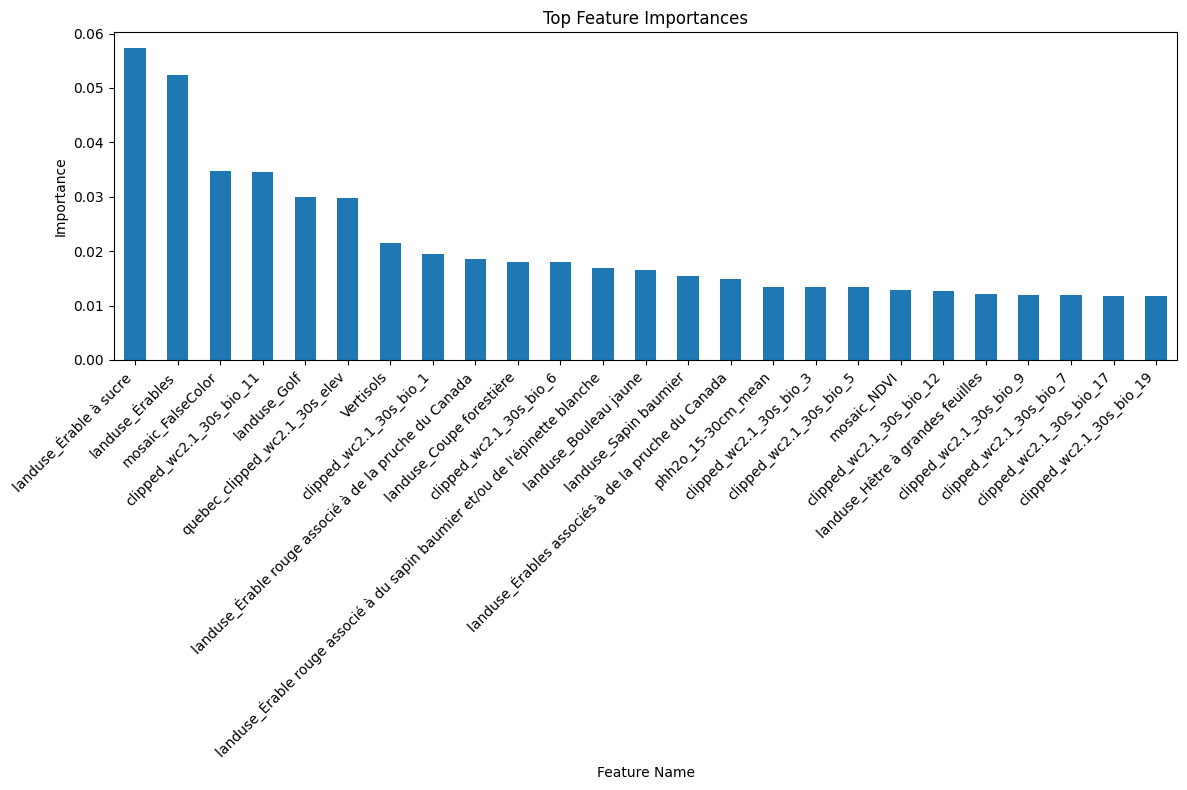

In [102]:
import pandas as pd

# Construct a DataFrame with feature names and their importances

feature_importance_df = get_feature_importance_for_species('ERP')
# Plot the top_n features using the DataFrame
plt.figure(figsize=(12, 8))
feature_importance_df.head(25).plot(
    kind='bar',
    x='feature_name',
    y='importance',
    legend=False,
    ax=plt.gca()
)
plt.title("Top Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature Name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [42]:
feature_importance_df[feature_importance_df['importance'] < 0.01].sort_values(by='importance', ascending=False)

,feature_name,importance
38,landuse_Pruche du Canada associée à des feuill...,0.009724
39,landuse_Bouleau blanc associé à du sapin baumi...,0.009663
40,clipped_wc2.1_30s_bio_15_value,0.009653
41,mosaic_stretched_value,0.009133
42,Luvisols_value,0.008979
...,...,...
191,landuse_6503,0.000000
190,landuse_6629,0.000000
189,landuse_Bouleau gris associé à des résineux to...,0.000000
188,Nitisols_value,0.000000


In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    #print("Model R^2 Score:", model.score(X_test, y_test))
    # Calculate accuracy
    accuracy = accuracy_score(y_test, np.round(y_pred))
    #print("Accuracy:", accuracy)
    train_accuracy = model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    return (accuracy, train_accuracy)

In [11]:
def evaluate_species(species_name, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats = None, cat_area_zonal_stats = None):# Define the target variable and features
    target = species_name  # Replace with the actual target column if different
    features = create_target_species_df(target, location_zonal_stats)

    model = xgb.XGBClassifier(
        objective='binary:logistic',  # or 'multi:softmax' for multiclass
        n_estimators=75,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        colsample_bytree=0.7,
        subsample=0.4,
    )
    
    accuracy_with_region = None
    if area_zonal_stats is not None and cat_area_zonal_stats is not None:
        merged_df_with_region = merge_data_inputs(features, location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        features_with_region = merged_df_with_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
        X_train_selected_with_region, X_test_selected_with_region, y_train_with_region, y_test_with_region = select_features(merged_df_with_region, target, features_with_region)
        accuracy_with_region, train_accuracy_with_region = evaluate_model(model, X_train_selected_with_region, y_train_with_region, X_test_selected_with_region, y_test_with_region)

    merged_df_without_region = merge_data_inputs(features,location_zonal_stats, cat_location_zonal_stats)
    features_without_region = merged_df_without_region.select_dtypes(include=['float64', 'int64']).columns.drop(target)
    X_train_selected_without_region, X_test_selected_without_region, y_train_without_region, y_test_without_region = select_features(merged_df_without_region, target, features_without_region)
    accuracy_without_region, train_accuracy_without_region = evaluate_model(model, X_train_selected_without_region, y_train_without_region, X_test_selected_without_region, y_test_without_region)
    
    return (accuracy_with_region, accuracy_without_region)

In [ ]:
#load df
location_zonal_stats = pd.read_csv('../data/misc/continuous_zonal_stats_res_12.csv')
cat_location_zonal_stats = pd.read_csv('../data/misc/cat_zonal_stats_res_12.csv')
location_zonal_stats_numeric_columns = location_zonal_stats.select_dtypes(include=['float64', 'int64']).columns
location_zonal_stats[location_zonal_stats_numeric_columns] = location_zonal_stats[location_zonal_stats_numeric_columns].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)
#merge zonal_stats with processed_species using h3_index
location_zonal_stats = location_zonal_stats.merge(
    processed_species[['h3_index', 'species_list']],
    on='h3_index',
    how='left'
)


def load_data_by_factor(factor):
        zonal_stats_x15 = pd.read_csv(f'../data/misc/continuous_zonal_stats_res_12_x{factor}.csv')
        cat_zonal_stats_x15 = pd.read_csv(f'../data/misc/cat_zonal_stats_res_12.csv_x{factor}.csv')

        # Normalize all numeric columns in zonal_stats between 0 and 1

        zonal_stats_x15_numeric_columns = zonal_stats_x15.select_dtypes(include=['float64', 'int64']).columns


        zonal_stats_x15[zonal_stats_x15_numeric_columns] = zonal_stats_x15[zonal_stats_x15_numeric_columns].apply(
            lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
        )
        return zonal_stats_x15, cat_zonal_stats_x15

In [17]:
import numpy as np

# Create an array starting at 1.25 and multiply each term by 1.25 until it exceeds 5
factors = 1.25 * np.array([1.25**i for i in range(int(np.log(8/1.25)/np.log(1.25)) + 1)])
print(factors)


#species_to_test = species_counts_df.sort_values(by='count', ascending=False).head(15).index.to_list()
species_to_test = ['ERS']
results = pd.DataFrame(columns=['Species', 'Accuracy', 'factor'])
for species in species_to_test:
    accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats)
    results = pd.concat([results, pd.DataFrame({
        'Species': [species],
        'Accuracy': [accuracy_without_region],
        'factor': [0]
    })], ignore_index=True)
    for factor in factors:
        area_zonal_stats, cat_area_zonal_stats = load_data_by_factor(factor)
        print(f"Processing {species} with factor: {factor}")
        accuracy_with_region, accuracy_without_region = evaluate_species(species,location_zonal_stats, cat_location_zonal_stats, area_zonal_stats, cat_area_zonal_stats)
        results = pd.concat([results, pd.DataFrame({
            'Species': [species],
            'Accuracy': [accuracy_with_region],
            'factor': [factor]
        })], ignore_index=True)

[1.25       1.5625     1.953125   2.44140625 3.05175781 3.81469727
 4.76837158 5.96046448 7.4505806 ]


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/tmp/ipykernel_8756/2058199435.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Processing ERS with factor: 1.25


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.5625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 1.953125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 2.44140625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.0517578125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 3.814697265625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 4.76837158203125


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 5.9604644775390625


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processing ERS with factor: 7.450580596923828


/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [18]:
# Select the row with the best accuracy for each species
best_accuracy_per_species = results.loc[results.groupby('Species')['Accuracy'].idxmax()]

# Ensure there is a row with factor == 0 for each species
accuracy_at_factor_0 = results[results['factor'] == 0].set_index('Species')['Accuracy']

# Calculate the difference between the best accuracy and the accuracy where factor == 0 for each species
best_accuracy_per_species['Accuracy_Difference'] = best_accuracy_per_species['Accuracy'] - best_accuracy_per_species['Species'].map(accuracy_at_factor_0)

# Display the result
best_accuracy_per_species

,Species,Accuracy,factor,Accuracy_Difference
5,ERS,0.83658,3.051758,0.017316


In [19]:
results

,Species,Accuracy,factor
0,ERS,0.819264,0
1,ERS,0.816017,1.25
2,ERS,0.831169,1.5625
3,ERS,0.819264,1.953125
4,ERS,0.834416,2.441406
5,ERS,0.836580,3.051758
6,ERS,0.834416,3.814697
7,ERS,0.824675,4.768372
8,ERS,0.832251,5.960464
9,ERS,0.834416,7.450581


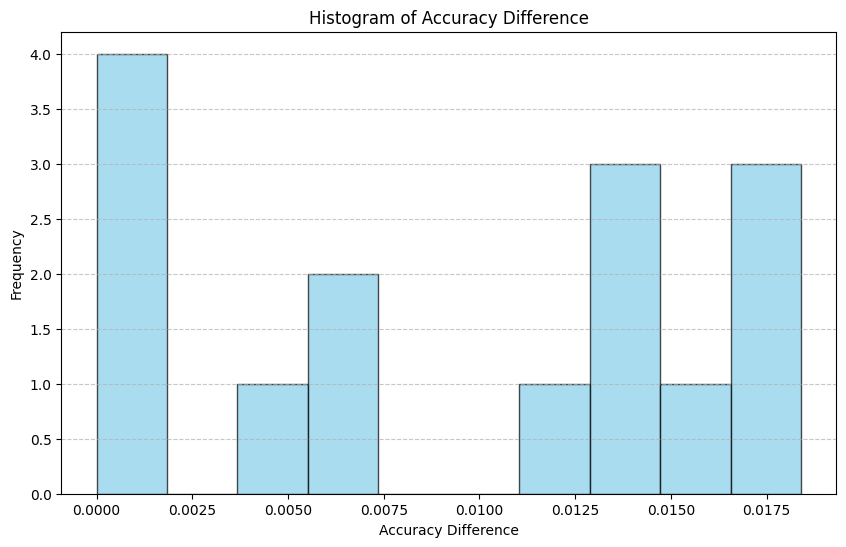

In [215]:
import matplotlib.pyplot as plt

# Plot Accuracy Difference as a histogram
plt.figure(figsize=(10, 6))
plt.hist(best_accuracy_per_species['Accuracy_Difference'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels, title, and grid
plt.xlabel('Accuracy Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy Difference')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


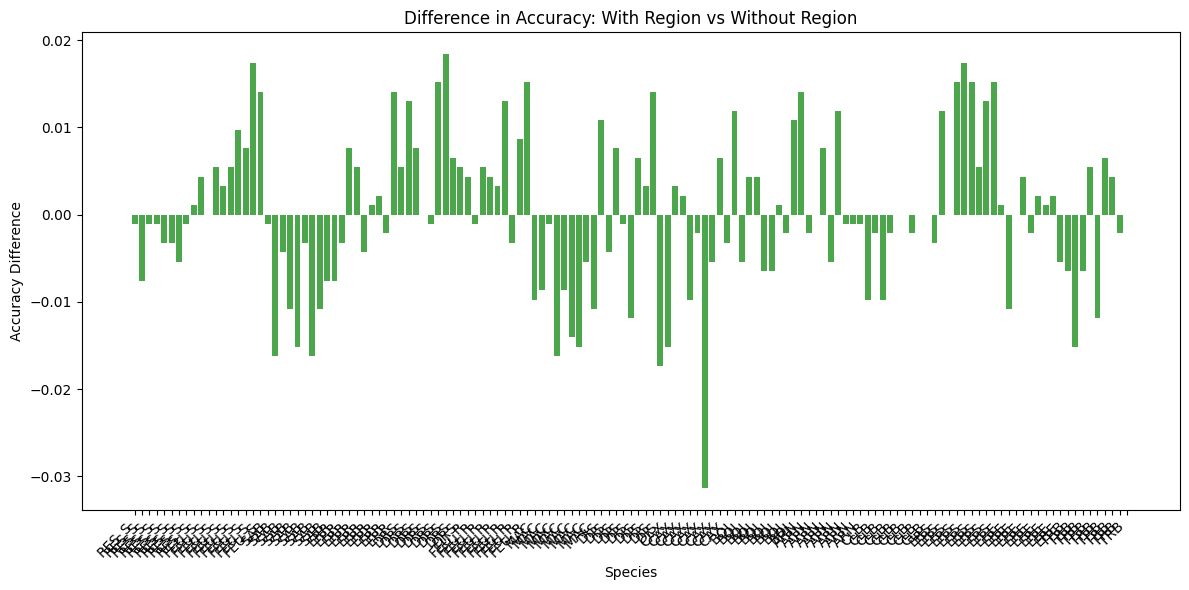

In [204]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the difference
results['Accuracy_Difference'] = results['Accuracy_With_Region'] - results['Accuracy_Without_Region']

# Set the positions of the bars
indices = np.arange(len(results))

# Plot the difference
plt.figure(figsize=(12, 6))
plt.bar(indices, results['Accuracy_Difference'], color='green', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Species')
plt.ylabel('Accuracy Difference')
plt.title('Difference in Accuracy: With Region vs Without Region')
plt.xticks(indices, results['Species'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56       244
           1       0.84      0.88      0.86       680

    accuracy                           0.78       924
   macro avg       0.72      0.70      0.71       924
weighted avg       0.77      0.78      0.78       924

[[126 118]
 [ 82 598]]


## Implementing 3D CNN

### Extracting data from hexagons

In [6]:
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import box, mapping
from rasterio.mask import mask
from rasterio.windows import Window
from rtree import index
import math

def extract_raster_values_for_multiple_h3_chunked(geometries, raster_path, chunk_size_mb=512):
    """
    Extract raster values for H3 geometries using chunked processing for large rasters.
    
    Parameters:
    -----------
    geometries : list
        List of H3 geometries
    raster_path : str
        Path to raster file
    chunk_size_mb : int
        Target chunk size in MB (default 512MB)
    
    Returns:
    --------
    list : Results for each geometry (out_image, clipped_bounds)
    """
    with rasterio.open(raster_path) as src:
        # Check if we need chunking
        raster_size_mb = (src.width * src.height * src.count * 
                         np.dtype(src.dtypes[0]).itemsize) / (1024 * 1024)
        print(f"Raster size: {raster_size_mb:.2f} MB, Chunk size: {chunk_size_mb} MB")
        if raster_size_mb <= chunk_size_mb:
            # Small raster - use original function
            return _extract_raster_values_original(geometries, src)
        
        # Large raster - use chunked processing
        else:
            print(f"Raster size {raster_size_mb:.2f} MB exceeds chunk size {chunk_size_mb} MB. Using chunked processing.")
            return _extract_raster_values_chunked(geometries, src, chunk_size_mb)

def _extract_raster_values_original(geometries, src):
    """Original function logic for small rasters"""
    # Reproject all geometries to match raster CRS
    h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
    h3_geometries = h3_geometries.to_crs(src.crs)

    # Get raster resolution
    res_x, res_y = src.res
    pixel_area = abs(res_x * res_y)

    results = []

    for geometry in h3_geometries:
        # Check if hexagon is smaller than raster resolution
        hex_area = geometry.area

        if hex_area < pixel_area:
            # Hex is smaller than a pixel - use point sampling instead
            centroid = geometry.centroid
            try:
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row + 1, col + 1)
                clipped_bounds = (left, bottom, right, top)
                results.append((out_image, clipped_bounds))
            except (IndexError, ValueError):
                results.append((None, None))
            continue

        # Convert to GeoJSON
        geometry_proj = mapping(geometry)

        # Create a bounding box from the raster bounds
        raster_bounds = box(*src.bounds)

        # Check overlap
        if not raster_bounds.intersects(geometry):
            results.append((None, None))
            continue

        try:
            # Mask the raster
            out_image, out_transform = mask(
                src,
                [geometry_proj],
                crop=True,
                filled=True,
                nodata=src.nodata
            )

            # Check if we got all NaN values
            if np.all(np.isnan(out_image)):
                centroid = geometry.centroid
                row, col = src.index(centroid.x, centroid.y)
                value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                out_image = np.array([[[value]]])
                left, top = src.xy(row, col)
                right, bottom = src.xy(row + 1, col + 1)
                out_transform = src.window_transform(((row, row + 1), (col, col + 1)))

            clipped_bounds = get_clipped_bounds(out_image, out_transform)
            results.append((out_image, clipped_bounds))

        except ValueError as e:
            if "Input shapes do not overlap raster" in str(e):
                results.append((None, None))
            else:
                raise

    return results

def _extract_raster_values_chunked(geometries, src, chunk_size_mb):
    """Chunked processing for large rasters"""
    # Reproject all geometries to match raster CRS
    h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
    h3_geometries = h3_geometries.to_crs(src.crs)
    
    # Get raster resolution
    res_x, res_y = src.res
    pixel_area = abs(res_x * res_y)
    
    # Calculate chunk dimensions
    bytes_per_pixel = np.dtype(src.dtypes[0]).itemsize * src.count
    target_pixels = (chunk_size_mb * 1024 * 1024) // bytes_per_pixel
    
    # Calculate square-ish chunks
    chunk_size = int(math.sqrt(target_pixels))
    chunk_rows = min(chunk_size, src.height)
    chunk_cols = min(chunk_size, src.width)
    
    # Create spatial index for geometries
    spatial_idx = index.Index()
    for i, geom in enumerate(h3_geometries):
        spatial_idx.insert(i, geom.bounds)
    
    # Initialize results
    results = [None] * len(h3_geometries)
    processed = set()
    
    # Process chunks
    for row_start in range(0, src.height, chunk_rows):
        for col_start in range(0, src.width, chunk_cols):
            row_end = min(row_start + chunk_rows, src.height)
            col_end = min(col_start + chunk_cols, src.width)
            
            # Create window for this chunk
            window = Window(col_start, row_start, col_end - col_start, row_end - row_start)
            
            # Get chunk bounds in geographic coordinates
            chunk_transform = src.window_transform(window)
            chunk_bounds = rasterio.windows.bounds(window, src.transform)
            chunk_geom = box(*chunk_bounds)
            
            # Add buffer to ensure geometries on edges are fully contained
            # Buffer size based on max possible H3 cell size in the area
            buffer_size = max(abs(res_x), abs(res_y)) * 10  # Adjust multiplier as needed
            buffered_chunk = chunk_geom.buffer(buffer_size)
            
            # Find geometries that intersect with this buffered chunk
            potential_indices = list(spatial_idx.intersection(buffered_chunk.bounds))
            
            if not potential_indices:
                continue
            
            # Filter to geometries that are fully contained in the buffered chunk
            # or haven't been processed yet
            chunk_geometries = []
            chunk_indices = []
            
            for idx in potential_indices:
                if idx in processed:
                    continue
                
                geom = h3_geometries.iloc[idx]
                
                # Check if geometry is fully contained in buffered chunk
                # or if its centroid is in the original (non-buffered) chunk
                if buffered_chunk.contains(geom) or chunk_geom.contains(geom.centroid):
                    chunk_geometries.append((idx, geom))
                    chunk_indices.append(idx)
            
            if not chunk_geometries:
                continue
            
            # Read this chunk
            try:
                chunk_data = src.read(window=window)
                
                # Create a temporary raster-like object for this chunk
                chunk_profile = src.profile.copy()
                chunk_profile.update({
                    'height': window.height,
                    'width': window.width,
                    'transform': chunk_transform
                })
                
                # Process geometries in this chunk
                for idx, geometry in chunk_geometries:
                    if idx in processed:
                        continue
                    
                    result = _process_single_geometry(
                        geometry, chunk_data, chunk_transform, 
                        src.nodata, pixel_area, chunk_bounds
                    )
                    
                    results[idx] = result
                    processed.add(idx)
                    
            except Exception as e:
                print(f"Error processing chunk at ({row_start}, {col_start}): {e}")
                continue
    
    # Handle any unprocessed geometries (fallback to point sampling)
    for i, geom in enumerate(h3_geometries):
        if i not in processed:
            try:
                centroid = geom.centroid
                row, col = src.index(centroid.x, centroid.y)
                if 0 <= row < src.height and 0 <= col < src.width:
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results[i] = (out_image, clipped_bounds)
                else:
                    results[i] = (None, None)
            except:
                results[i] = (None, None)
    
    return results

def _process_single_geometry(geometry, chunk_data, chunk_transform, nodata, pixel_area, chunk_bounds):
    """Process a single geometry against chunk data"""
    hex_area = geometry.area
    
    # Check if hexagon is smaller than raster resolution
    if hex_area < pixel_area:
        # Use point sampling
        centroid = geometry.centroid
        try:
            # Convert centroid to chunk pixel coordinates
            col, row = ~chunk_transform * (centroid.x, centroid.y)
            row, col = int(row), int(col)
            
            if 0 <= row < chunk_data.shape[1] and 0 <= col < chunk_data.shape[2]:
                value = chunk_data[0, row, col]
                out_image = np.array([[[value]]])
                # Convert back to geographic coordinates
                x, y = chunk_transform * (col, row)
                x2, y2 = chunk_transform * (col + 1, row + 1)
                clipped_bounds = (min(x, x2), min(y, y2), max(x, x2), max(y, y2))
                return (out_image, clipped_bounds)
            else:
                return (None, None)
        except:
            return (None, None)
    
    # Create chunk bounds box for intersection check
    chunk_box = box(*chunk_bounds)
    
    # Check overlap
    if not chunk_box.intersects(geometry):
        return (None, None)
    
    try:
        # For chunked processing, we need to create a temporary in-memory raster
        # This is a simplified approach - you might want to use rasterio.MemoryFile for more complex cases
        from rasterio.mask import mask
        from rasterio import MemoryFile
        
        # Create temporary memory file with chunk data
        with MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=chunk_data.shape[1],
                width=chunk_data.shape[2],
                count=chunk_data.shape[0],
                dtype=chunk_data.dtype,
                crs=None,  # Will be handled by transform
                transform=chunk_transform,
                nodata=nodata
            ) as temp_src:
                temp_src.write(chunk_data)
                
                # Now apply mask
                geometry_proj = mapping(geometry)
                out_image, out_transform = mask(
                    temp_src,
                    [geometry_proj],
                    crop=True,
                    filled=True,
                    nodata=nodata
                )
                
                # Check if we got all NaN values
                if np.all(np.isnan(out_image)) or np.all(out_image == nodata):
                    # Fallback to centroid sampling
                    centroid = geometry.centroid
                    col, row = ~chunk_transform * (centroid.x, centroid.y)
                    row, col = int(row), int(col)
                    
                    if 0 <= row < chunk_data.shape[1] and 0 <= col < chunk_data.shape[2]:
                        value = chunk_data[0, row, col]
                        out_image = np.array([[[value]]])
                        x, y = chunk_transform * (col, row)
                        x2, y2 = chunk_transform * (col + 1, row + 1)
                        out_transform = rasterio.transform.from_bounds(
                            min(x, x2), min(y, y2), max(x, x2), max(y, y2), 1, 1
                        )
                
                clipped_bounds = get_clipped_bounds(out_image, out_transform)
                return (out_image, clipped_bounds)
                
    except ValueError as e:
        if "Input shapes do not overlap raster" in str(e):
            return (None, None)
        else:
            raise
    except Exception:
        return (None, None)

def get_clipped_bounds(out_image, out_transform):
    """Helper function to get bounds from image and transform"""
    height, width = out_image.shape[1], out_image.shape[2]
    left, top = out_transform * (0, 0)
    right, bottom = out_transform * (width, height)
    return (left, bottom, right, top)



In [ ]:
upscale_factor = 2
bounding_box = bounding_box
with rasterio.open("../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif") as src:

    data = src.read(1, window=Window(
        bounding_box[0] // upscale_factor, 
        bounding_box[1] // upscale_factor, 
        (bounding_box[2] - bounding_box[0]) // upscale_factor, 
        (bounding_box[3] - bounding_box[1]) // upscale_factor
    ))


In [17]:
# Example usage:
h3_cells = processed_species['h3_index'].values
expanded_cells = [expand_hexagon(h3_cell, 50) for h3_cell in h3_cells]
results = extract_raster_values_for_multiple_h3_chunked(
    geometries=expanded_cells,
    raster_path="../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif",
    #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif",
    chunk_size_mb=5000  # Adjust based on your memory constraints
)

Raster size: 1254.00 MB, Chunk size: 5000 MB


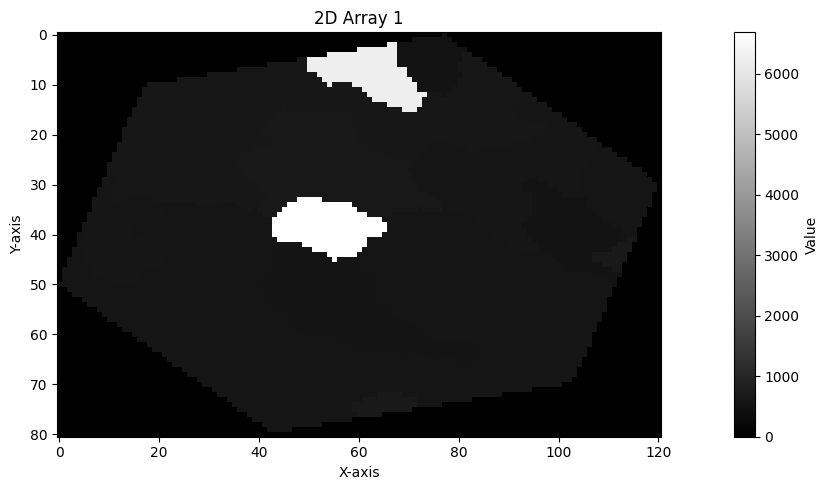

In [20]:
output, bounds = results[3]
visualize_2d_array([output[0]])

In [19]:
import rasterio
def extract_raster_values_for_multiple_h3(geometries, raster_path):
    with rasterio.open(raster_path) as src:
        # Reproject all geometries to match raster CRS
        h3_geometries = gpd.GeoSeries(geometries, crs="EPSG:4326")
        h3_geometries = h3_geometries.to_crs(src.crs)

        # Get raster resolution
        res_x, res_y = src.res
        pixel_area = abs(res_x * res_y)

        results = []

        for geometry in h3_geometries:
            # Check if hexagon is smaller than raster resolution
            hex_area = geometry.area

            if hex_area < pixel_area:
                # Hex is smaller than a pixel - use point sampling instead
                centroid = geometry.centroid
                try:
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    clipped_bounds = (left, bottom, right, top)
                    results.append((out_image, clipped_bounds))
                except (IndexError, ValueError):
                    results.append((None, None))
                continue

            # Convert to GeoJSON
            geometry_proj = mapping(geometry)

            # Create a bounding box from the raster bounds
            raster_bounds = box(*src.bounds)

            # Check overlap
            if not raster_bounds.intersects(geometry):
                results.append((None, None))
                continue

            try:
                # Mask the raster
                out_image, out_transform = mask(
                    src,
                    [geometry_proj],
                    crop=True,
                    filled=True,
                    nodata=src.nodata
                )

                # Check if we got all NaN values
                if np.all(np.isnan(out_image)):
                    centroid = geometry.centroid
                    row, col = src.index(centroid.x, centroid.y)
                    value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
                    out_image = np.array([[[value]]])
                    left, top = src.xy(row, col)
                    right, bottom = src.xy(row + 1, col + 1)
                    out_transform = src.window_transform(((row, row + 1), (col, col + 1)))

                clipped_bounds = get_clipped_bounds(out_image, out_transform)
                results.append((out_image, clipped_bounds))

            except ValueError as e:
                if "Input shapes do not overlap raster" in str(e):
                    results.append((None, None))
                else:
                    raise

        return results


### Normalizing data
For the satelitte images, the resolution of hexagons are 73x110

For the landuse data, the resolution of hexagons are 161x241

For the climate data, the resolution of hexagons are 

Could be an interesting idea to test if a FCN produces better results since it can take multiple resolutions as input.

In [74]:
import numpy as np
from skimage.transform import resize

def resize_raster(input_raster, target_shape):
    """
    Resize the raster input_raster to the target shape using interpolation.   
    
    Parameters:
    - input_raster: The input raster array to be resized.
    - target_shape: The desired shape (height, width) for the output raster.
    
    Returns:
    - resized_image: The resized raster array.
    """
    # Assuming `output` is a 2D or 3D numpy array
    if len(input_raster.shape) == 2:
        # For single band raster
        resized_image = resize(input_raster, target_shape, order=1, anti_aliasing=True, mode='edge')  # bilinear
    elif len(input_raster.shape) == 3:
        # For multi-band raster
        resized_image = np.stack([
            resize(band, target_shape, order=1, anti_aliasing=True, mode='edge') for band in input_raster
        ], axis=-1)
    else:
        raise ValueError("Unsupported output shape: {}".format(input_raster.shape))
    
    return resized_image

def visualize_2d_array(arrays, plots_per_row=5):
    num_arrays = len(arrays)
    num_rows = int(np.ceil(num_arrays / plots_per_row))
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 4, num_rows * 4))
    axes = np.array(axes).reshape(num_rows, plots_per_row)
    for idx, array in enumerate(arrays):
        row = idx // plots_per_row
        col = idx % plots_per_row
        ax = axes[row, col]
        im = ax.imshow(array, cmap='gray')
        ax.set_title(f'2D Array {idx+1}')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        #fig.colorbar(im, ax=ax, orientation='vertical', label='Value')
    # Hide any unused subplots
    for idx in range(num_arrays, num_rows * plots_per_row):
        row = idx // plots_per_row
        col = idx % plots_per_row
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()



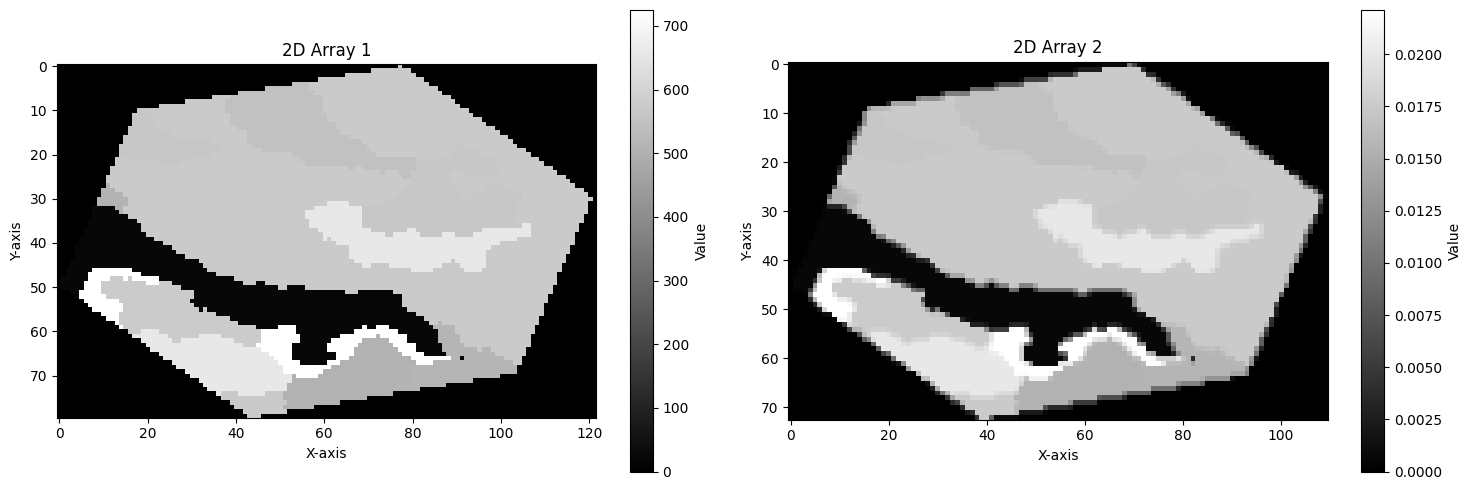

In [ ]:
h3_cells = processed_species['h3_index'].values[:10]
expanded_cells = [expand_hexagon(h3_cell, 50) for h3_cell in h3_cells]

rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=expanded_cells,
        raster_path="../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif",
        #raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )
output, bounds = rgb_raster[0]
 
target_shape = (73, 110)
resized_image = resize_raster(output[0], target_shape)  # Resize to 100x100 pixels
visualize_2d_array([output[0], resized_image])

Original shape: (109, 164)
Resized shape: (73, 110)


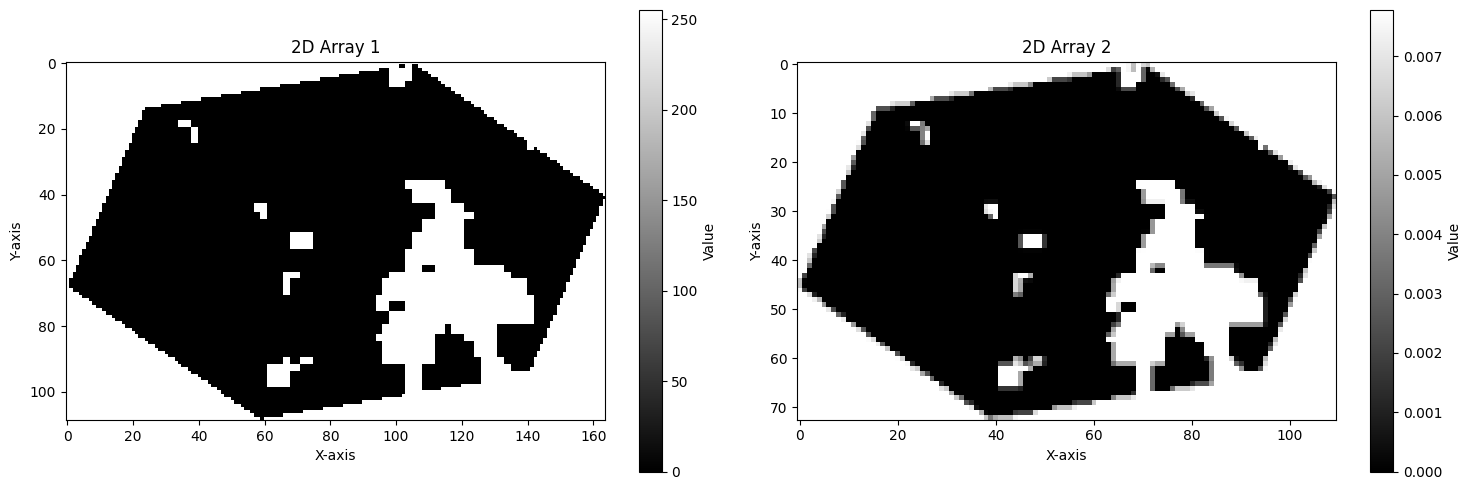

In [119]:
import numpy as np
from skimage.transform import resize

output, bounds = rgb_raster[4]
output = output[0]  # Assuming the first band is what you want to visualize
# Assuming `image` is your input array (73x110 or 161x241)
original_shape = output.shape
target_shape = (73, 110)  # or (73, 110) for downsampling

# Resize using interpolation (options: 'nearest', 'bilinear', 'bicubic', 'lanczos')
resized_image = resize(output, target_shape, order=1, anti_aliasing=True, mode='edge')  # bicubic

# For remote sensing, 'bilinear' (order=1) or 'bicubic' (order=3) are common
print("Original shape:", original_shape)
print("Resized shape:", resized_image.shape)
visualize_2d_array([output, resized_image])

In [257]:
def extract_all_bands_for_geom(geometries):
    """
    Extract all bands for the given geometries from the remote sensing data.
    Remote sensing data includes RGB, False Color, and SWIR bands.
    Extracted bands: B4, B3, B2 (RGB), B8 (False Color), B11 (SWIR).
    """
    rgb_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif"
    )
    false_color_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif"
    )
    swir_raster = extract_raster_values_for_multiple_h3(
        geometries=geometries,
        raster_path="../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif"
    )
    results = []
    for i, (rgb_output, bounds) in enumerate(rgb_raster):
        B4, B3, B2 = rgb_output
        B8 = false_color_raster[i][0][0]
        B11 = swir_raster[i][0][0]
        results.append(np.stack([B4, B3, B2, B8, B11]))

    target_shape = tuple(np.max([band.shape for band in results], axis=0))
    results = np.array([pad_or_crop_to_shape(band, target_shape) for band in results])
    return results

def extract_all_bands_for_uni_band(geometries, raster_paths):
    extracted_bands = []
    for raster_i, raster_path in enumerate(raster_paths):
        print(f"Processing raster {raster_i + 1}/{len(raster_paths)}: {raster_path}")
        raster_values = extract_raster_values_for_multiple_h3(
            geometries=geometries,
            raster_path=raster_path
        )
        extracted_bands.append([])
        for i, (output, bounds) in enumerate(raster_values):
            if output is not None:
                extracted_bands[raster_i].append(output[0])  # Assuming single band output
            else:
                extracted_bands.append(None)
        
    return extracted_bands
def extract_resize_for_other_data(geometries, raster_paths, target_shape=(73, 110), saving=False):
    extracted_bands = extract_all_bands_for_uni_band(geometries, raster_paths)
    # extracted_bands: list of [band][cell][x, y]
    num_bands = len(extracted_bands)
    num_cells = len(extracted_bands[0]) if num_bands > 0 else 0

    # Prepare a list to collect resized bands for each cell
    resized_bands_per_cell = []
    for cell_idx in range(num_cells):
        cell_bands = []
        for band_idx in range(num_bands):
            band = extracted_bands[band_idx]
            hex_band = band[cell_idx] if band is not None else None
            if hex_band is not None:
                resized_hex = resize_raster(hex_band, target_shape)
                cell_bands.append(resized_hex)
            else:
                cell_bands.append(np.full(target_shape, np.nan))  # Fill with NaN if missing
        # Stack bands for this cell: (bands, x, y)
        cell_bands = np.stack(cell_bands, axis=0)
        resized_bands_per_cell.append(cell_bands)
    # Stack all cells: (cell, bands, x, y)
    resized_bands = np.stack(resized_bands_per_cell, axis=0)
    return resized_bands

import numpy as np

def pad_or_crop_to_shape(array, target_shape):
    """
    Pads or crops a 3D array to the target shape.
    
    Parameters:
    ----------
    array : numpy.ndarray
        The input array to be padded or cropped.
    target_shape : tuple
        The target shape (height, width, depth).
    
    Returns:
    -------
    numpy.ndarray
        The array padded or cropped to the target shape.
    """
    current_shape = array.shape
    padded_array = np.zeros(target_shape, dtype=array.dtype)
    
    # Calculate the cropping or padding indices
    min_height = min(current_shape[0], target_shape[0])
    min_width = min(current_shape[1], target_shape[1])
    min_depth = min(current_shape[2], target_shape[2])
    
    # Copy the overlapping region
    padded_array[:min_height, :min_width, :min_depth] = array[:min_height, :min_width, :min_depth]
    return padded_array


### Extracting data from hexagons into np files for training with feature selections

In [15]:
#fetch all files in the folders: ['../data/data_layers/soil_grid', '../data/data_layers/worldClim', '../data/data_layers/landuse']
import os
# Define directories to search for raster files
def fetch_raster_files(include_files=None):
    directories = [
        '../data/data_layers/soil_grid',
        '../data/data_layers/worldClim',
        '../data/data_layers/landuse'
    ]
    raster_files = []
    for directory in directories:
        for root, _, files in os.walk(directory):
            for file in files:
                if include_files is not None:
                    #if ends with .tif and there is no match in exclude_files
                    if file.endswith('.tif') and any(exclude in file for exclude in include_files):
                        raster_files.append(os.path.join(root, file))
                else:
                    if file.endswith('.tif'):
                        raster_files.append(os.path.join(root, file))
    return raster_files


#extract only the file directory name
#raster_files = fetch_raster_files(directories, include_files=['utilisation_territoire_2020'])

#get directory names from the file paths
#raster_file_dirs = [os.path.basename(file) for file in directories]


###  Normalizing data for training min/max scaling

In [48]:
def normalize_data(data):
    """
    Normalize the data to the range [0, 1] for each band.
    
    Parameters:
    ----------
    data : numpy.ndarray
        The input data array with shape (cells, bands, height, width).
    
    Returns:
    -------
    numpy.ndarray
        The normalized data array.
    """
    if data.ndim != 4:
        raise ValueError("Input data must be a 4D array with shape (cells, bands, height, width).")
    
    # Initialize an array to hold normalized data
    normalized_data = np.zeros_like(data)
    
    # Normalize each band independently
    for band in range(data.shape[1]):
        band_data = data[:, band, :, :]
        band_min = np.nanmin(band_data)
        band_max = np.nanmax(band_data)
        
        if band_max > band_min:
            normalized_data[:, band, :, :] = (band_data - band_min) / (band_max - band_min)
        else:
            normalized_data[:, band, :, :] = 0  # or np.nan if you prefer
    
    return normalized_data
    arr_norm = data.copy()
    for band in range(data.shape[1]):
        band_data = data[:, band, :, :]
        band_min = np.nanmin(band_data)
        band_max = np.nanmax(band_data)
        if band_max > band_min:
            arr_norm[:, band, :, :] = (band_data - band_min) / (band_max - band_min)
        else:
            arr_norm[:, band, :, :] = 0  # or np.nan if you prefer
    return arr_norm

In [234]:
#always extract all satelitte bands
h3_cells = processed_species['h3_index'].values[:100]
expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
sat_bands = extract_all_bands_for_geom(expanded_cells)
arr_norm = normalize_data(sat_bands)
visualize_2d_array([arr_norm[0, 0]])  # Visualize the first band of the first cell

AttributeError: 'list' object has no attribute 'shape'

In [249]:
def get_max_shape(expanded_cells, raster_paths):
    test_no_resize = extract_all_bands_for_uni_band(
        geometries=expanded_cells[:10],
        raster_paths=raster_paths
    )

    max_shape = (0,0)
    for bands in test_no_resize:
        for cell in bands:
            max_shape = np.maximum(max_shape, cell.shape)
    return max_shape

In [248]:
parent_folders = [os.path.basename(os.path.dirname(f)) for f in raster_files]
file_df = pd.DataFrame({
    'file_path': raster_files,
    'parent_folder': parent_folders
})
#iterate trough parent_folder groups
for folder in file_df['parent_folder'].unique():
    group_file_paths = file_df[file_df['parent_folder'] == folder]['file_path'].values
    print(group_file_paths)
    print(f"Processing folder: {folder}")
    # Further processing for each group

['../data/data_layers/soil_grid/Leptosols.tif'
 '../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif'
 '../data/data_layers/soil_grid/Phaeozems.tif'
 '../data/data_layers/soil_grid/Vertisols.tif'
 '../data/data_layers/soil_grid/Podzols.tif'
 '../data/data_layers/soil_grid/Histosols.tif']
Processing folder: soil_grid
['../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_16.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_11.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_13.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_7.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_2.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_3.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_4.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_19.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_18.tif'
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_17.tif'
 '.

In [244]:
file_df

,file_path,parent_folder
0,../data/data_layers/soil_grid/Leptosols.tif,soil_grid
1,../data/data_layers/soil_grid/phh2o_15-30cm_me...,soil_grid
2,../data/data_layers/soil_grid/Phaeozems.tif,soil_grid
3,../data/data_layers/soil_grid/Vertisols.tif,soil_grid
4,../data/data_layers/soil_grid/Podzols.tif,soil_grid
5,../data/data_layers/soil_grid/Histosols.tif,soil_grid
6,../data/data_layers/worldClim/clipped_wc2.1_30...,worldClim
7,../data/data_layers/worldClim/clipped_wc2.1_30...,worldClim
8,../data/data_layers/worldClim/clipped_wc2.1_30...,worldClim
9,../data/data_layers/worldClim/clipped_wc2.1_30...,worldClim


In [261]:
def prepare_data_with_feature_importance(feature_importance_df, with_resize=True):
    """
    Prepare data for feature importance analysis by extracting and resizing bands.
    Process all satelitte bands, environmental data from SoilGrids, WorldClim, and landuse data.
    Creates 3 different files: environment.npy, sat_bands.npy, and landuse.npy.
    Parameters:
    ----------
    feature_importance_df : pandas.DataFrame
        DataFrame containing feature importance information.
    raster_files : list
        List of raster file paths to extract data from.
    
    Returns:
    -------
    None
    """
    
    #always extract all satelitte bands
    h3_cells = processed_species['h3_index'].values
    expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
    sat_bands = extract_all_bands_for_geom(expanded_cells)
    sat_bands = normalize_data(sat_bands)  # Normalize the satellite bands
    np.save(f'../data/misc/sat_bands.npy', sat_bands)
    target_shape = sat_bands[0].shape
    print("Processed satellite bands shape:", target_shape)

    raster_files = fetch_raster_files(include_files=feature_importance_df['feature_name'].values)
    
    # Further processing for each group
    # Extract and resize bands for each raster file
    if with_resize:
        other_bands = extract_resize_for_other_data(
            geometries=expanded_cells,
            raster_paths=raster_files,
            target_shape=target_shape[1:]
        )
        other_bands = normalize_data(other_bands)  # Normalize the environmental bands
        np.save(f'../data/misc/environment.npy', other_bands)
    #if no resize process each fodlers separately to not crop different data soures togheter
    else:
        parent_folders = [os.path.basename(os.path.dirname(f)) for f in raster_files]
        file_df = pd.DataFrame({
            'file_path': raster_files,
            'parent_folder': parent_folders
        })
        for folder in file_df['parent_folder'].unique():
            group_file_paths = file_df[file_df['parent_folder'] == folder]['file_path'].values
            max_shape = get_max_shape(expanded_cells, group_file_paths)
            other_bands = extract_resize_for_other_data(
                geometries=expanded_cells,
                raster_paths=group_file_paths,
                target_shape=max_shape  # Skipping depth dimension for this method, only need height and width
            )
            # Save np array to file
            other_bands = normalize_data(other_bands)  # Normalize the environmental bands
            np.save(f'../data/misc/{folder}.npy', other_bands)
            print(f"Processed {folder} bands shape:", other_bands.shape)

    landuse_band = extract_resize_for_other_data(
        geometries=expanded_cells,
        raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
        target_shape=target_shape[1:]  # Skipping depth dimension for this method, only need height and width
    )
    # Save np array to file
    np.save(f'../data/misc/landuse.npy', landuse_band)
    print("Processed landuse bands shape:", landuse_band.shape)

# # Extract and resize bands for each directory
# for dir in directories:
#     dir_name = os.path.basename(dir)
#     raster_paths = fetch_raster_files([dir])
#     other_bands = extract_resize_for_other_data(
#         geometries=expanded_cells,
#         #raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',],
#         raster_paths=raster_paths,
#         target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
#     )
#     print(f"Extracted and resized bands for {dir_name}: {other_bands.shape}")
#     #save np array to file
#     np.save(f'../data/misc/{dir_name}.npy', other_bands)

In [ ]:
# def prepare_data_with_feature_importance(feature_importance_df, with_resize=True):
#     """
#     Prepare data for feature importance analysis by extracting and resizing bands.
#     Process all satelitte bands, environmental data from SoilGrids, WorldClim, and landuse data.
#     Creates 3 different files: environment.npy, sat_bands.npy, and landuse.npy.
#     Parameters:
#     ----------
#     feature_importance_df : pandas.DataFrame
#         DataFrame containing feature importance information.
#     raster_files : list
#         List of raster file paths to extract data from.
    
#     Returns:
#     -------
#     None
#     """
    
#     #always extract all satelitte bands
#     h3_cells = processed_species['h3_index'].values
#     expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
#     sat_bands = extract_all_bands_for_geom(expanded_cells)
#     sat_bands = normalize_data(sat_bands)  # Normalize the satellite bands
#     np.save(f'../data/misc/sat_bands.npy', sat_bands)
#     target_shape = sat_bands[0].shape
#     print("Processed satellite bands shape:", target_shape)
#     raster_files = fetch_raster_files(include_files=feature_importance_df['feature_name'].values)
    
#     # Extract and resize bands for each raster file
#     if with_resize:
#         other_bands = extract_resize_for_other_data(
#             geometries=expanded_cells,
#             raster_paths=raster_files,
#             target_shape=target_shape[1:],
#             with_resize=with_resize
#         )
#     # Save np array to file
#     other_bands = normalize_data(other_bands)  # Normalize the environmental bands
#     np.save(f'../data/misc/environment.npy', other_bands)
#     print("Processed environmental bands shape:", other_bands.shape)
#     if with_resize:
#         landuse_band = extract_resize_for_other_data(
#             geometries=expanded_cells,
#             raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
#             target_shape=target_shape[1:]  # Skipping depth dimension for this method, only need height and width
#         )
#     else:
#         max_shape = get_max_shape(expanded_cells, ['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'])
#         landuse_band = extract_resize_for_other_data(
#             geometries=expanded_cells,
#             raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
#             target_shape=max_shape  # Skipping depth dimension for this method, only need height and width
#         )
#     # Save np array to file
#     np.save(f'../data/misc/landuse.npy', landuse_band)
#     print("Processed landuse bands shape:", landuse_band.shape)

# # # Extract and resize bands for each directory
# # for dir in directories:
# #     dir_name = os.path.basename(dir)
# #     raster_paths = fetch_raster_files([dir])
# #     other_bands = extract_resize_for_other_data(
# #         geometries=expanded_cells,
# #         #raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif',],
# #         raster_paths=raster_paths,
# #         target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
# #     )
# #     print(f"Extracted and resized bands for {dir_name}: {other_bands.shape}")
# #     #save np array to file
# #     np.save(f'../data/misc/{dir_name}.npy', other_bands)

['../data/data_layers/soil_grid/Leptosols.tif',
 '../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif',
 '../data/data_layers/soil_grid/Phaeozems.tif',
 '../data/data_layers/soil_grid/Vertisols.tif',
 '../data/data_layers/soil_grid/Podzols.tif',
 '../data/data_layers/soil_grid/Histosols.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_16.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_11.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_13.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_7.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_2.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_3.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_4.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_19.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_18.tif',
 '../data/data_layers/worldClim/clipped_wc2.1_30s_bio_17.tif',
 '../data/data_l

In [ ]:
feature_importance_df = get_feature_importance_for_species('ERP', remove_landuse=True, treshold=0.01)
raster_files = fetch_raster_files(include_files=feature_importance_df['feature_name'].values)
prepare_data_with_feature_importance(feature_importance_df)

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Processed satellite bands shape: (5, 74, 111)
Processing raster 1/6: ../data/data_layers/soil_grid/Leptosols.tif
Processing raster 2/6: ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing raster 3/6: ../data/data_layers/soil_grid/Phaeozems.tif
Processing raster 4/6: ../data/data_layers/soil_grid/Vertisols.tif
Processing raster 5/6: ../data/data_layers/soil_grid/Podzols.tif
Processing raster 6/6: ../data/data_layers/soil_grid/Histosols.tif
Processing raster 1/6: ../data/data_layers/soil_grid/Leptosols.tif
Processing raster 2/6: ../data/data_layers/soil_grid/phh2o_15-30cm_mean.tif
Processing raster 3/6: ../data/data_layers/soil_grid/Phaeozems.tif
Processing raster 4/6: ../data/data_layers/soil_grid/Vertisols.tif
Processing raster 5/6: ../data/data_layers/soil_grid/Podzols.tif
Processing raster 6/6: ../data/data_layers/soil_grid/Histosols.tif
Processed soil_grid bands shape: (100, 6, 23, 34)
Processing raster 1/20: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif
Pro

### Figuring out how to stack bands 

POLYGON ((-75.01934286056813 47.04929490295433, -75.01949196676215 47.04927092138622, -75.01953577067272 47.04917341771896, -75.01943046890267 47.04909989576222, -75.01928136326327 47.049123877221945, -75.01923755883931 47.049221380746815, -75.01934286056813 47.04929490295433))


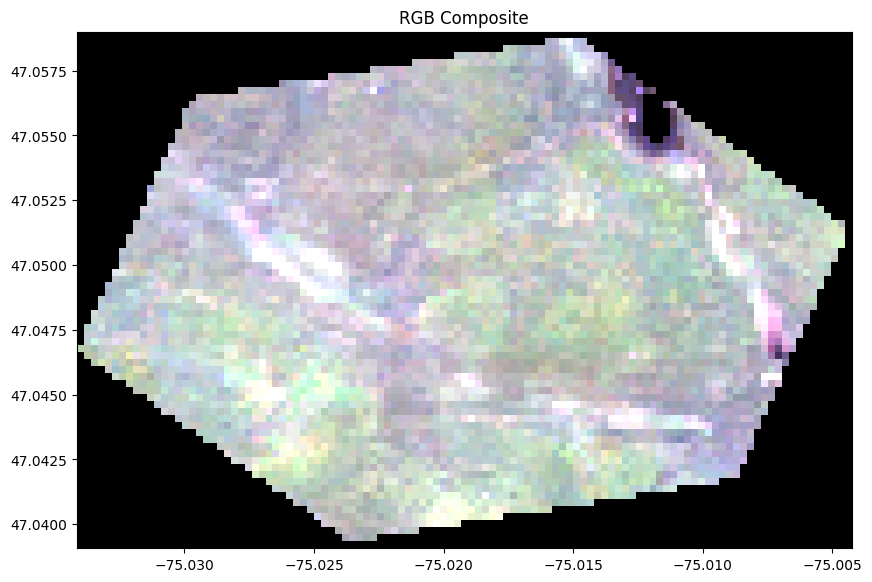

In [52]:
import matplotlib.pyplot as plt

geom = processed_species['geometry'].values[1000]
h3_cell = processed_species['h3_index'].values[1000]
expanded_geom = expand_hexagon(h3_cell, 100)  # Expand the hexagon by 10% of its size
#print(expanded_geom)
print(geom)
out_image_rgb, clipped_bounds_rgb = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_RGB.tif")
out_image_false_color, clipped_bounds_false_color = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_FalseColor.tif")
out_image_ndvi, clipped_bounds_ndvi = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_NDVI.tif")
out_image_swir, clipped_bounds_swir = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/satelitte_data/quebec_mosaic/mosaic_SWIR.tif")
#out_image, clipped_bounds = extract_raster_values_for_h3(expanded_geom, "../data/data_layers/landuse/utilisation_territoire_2020_reprojected.tif")


# Plot the normalized data with color scale from 0 to 1
#vis_one_band_raster(out_image, clipped_bounds)
# Plot the RGB composite
vis_rgb_raster(out_image, clipped_bounds)

    # Define band combinations
    band_sets = {
        "RGB": ['B4', 'B3', 'B2'],
        "FalseColor": ['B8', 'B4', 'B3'],
        "SWIR": ['B11', 'B8'],
        "NDVI": ['NDVI'],
        "moisture": ['moisture']
    }

In [ ]:
B4 = out_image_rgb[0]
B3 = out_image_rgb[1]
B2 = out_image_rgb[2]
B8 = out_image_false_color[0]
B11 = out_image_swir[0]

# stackk all the bands
stacked_bands = np.stack([B4, B3, B2, B8, B11], axis=0)

In [57]:
stacked_bands.shape

(5, 74, 111)

In [78]:
# Calculate padding amounts (top/bottom)
pad_total = 111 - 74
pad_top = pad_total // 2
pad_bottom = pad_total - pad_top

def pad_band(band):
    # Pad height (axis=0), leave width (axis=1) unchanged
    padded_tile = np.pad(
        band,
        pad_width=((pad_top, pad_bottom), (0, 0)),  # Pad only height, no padding for width
        mode='constant',  # For zero-padding
        constant_values=0  # Or use `mode='reflect'`
    )
    return padded_tile

B2_padded = pad_band(B2)
B3_padded = pad_band(B3)
B4_padded = pad_band(B4)

stacked_bands_padded = np.stack([B4_padded, B3_padded, B2_padded], axis=0)

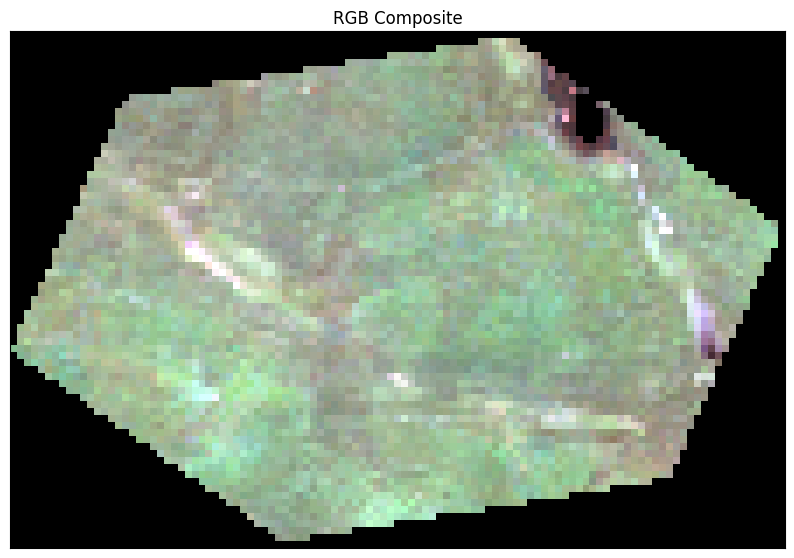

<Axes: title={'center': 'RGB Composite'}>

In [80]:
import earthpy.plot as ep

ep.plot_rgb(
    stacked_bands,
    rgb=(2, 1, 0),
    stretch=True,
    title="RGB Composite",
    figsize=(10, 10),
    str_clip= 0.2
)

### Data augmentation testing

In [195]:
stacked_bands.shape

(5, 74, 111)

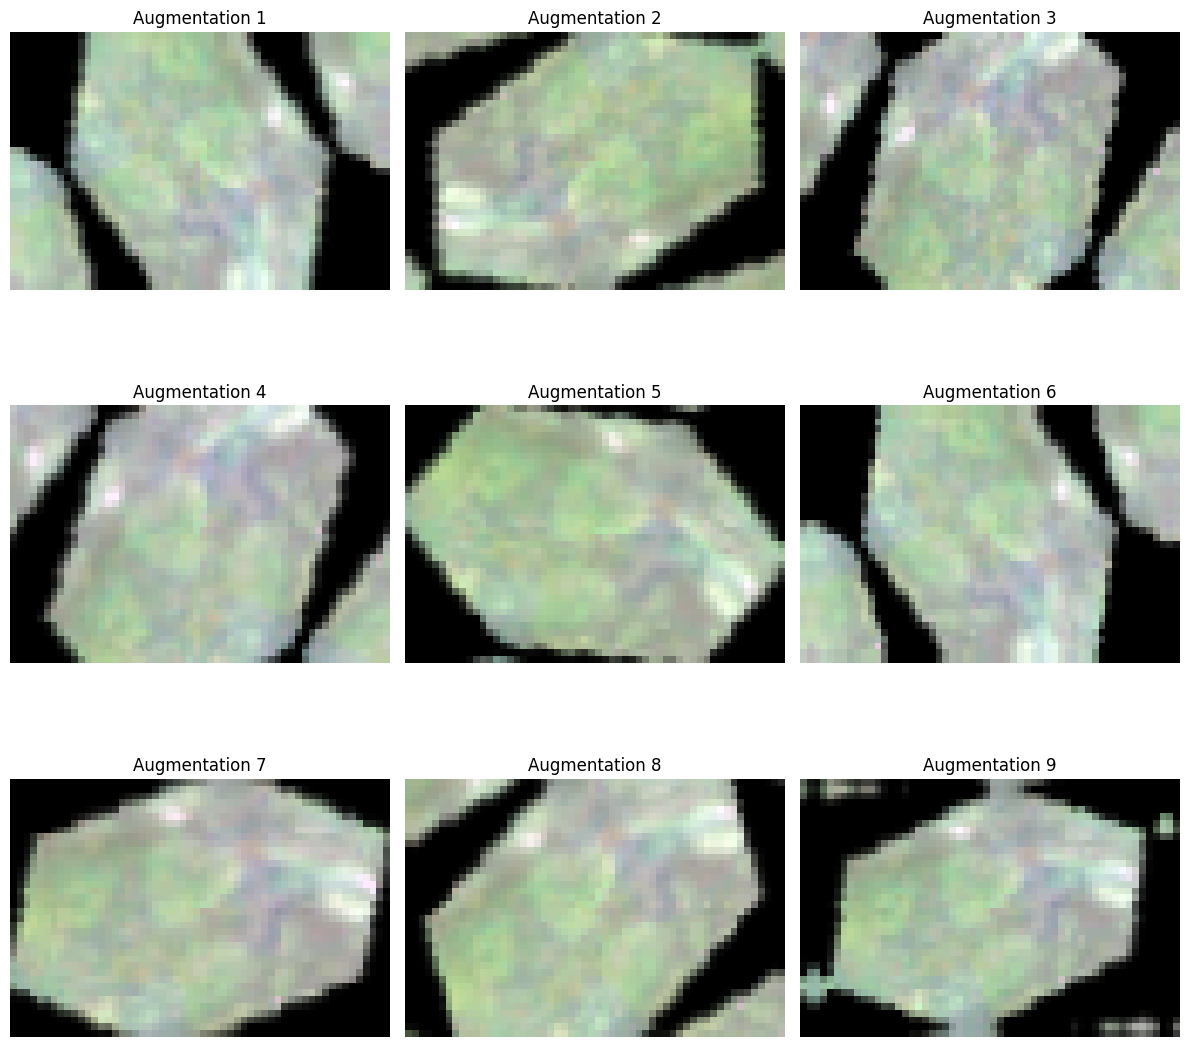

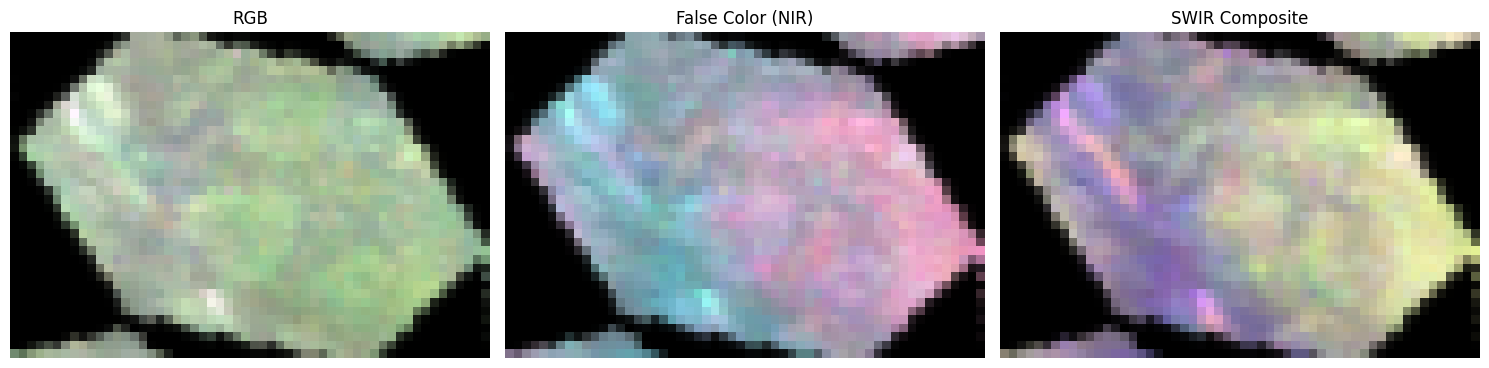

In [199]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Define augmentation sequence
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    # No intensity/brightness transformations since spectral values have physical meaning
])

# Function to visualize RGB composite from multispectral data
def visualize_rgb(image_array, band_indices=(0, 1, 2)):
    """
    Visualize RGB composite from bands in multispectral image
    
    Parameters:
    -----------
    image_array: Array with shape (bands, height, width) or (height, width, bands)
    band_indices: Tuple with indices for (R, G, B) bands
    """
    # Check if bands are in the first dimension
    if image_array.shape[0] < image_array.shape[-1]:
        # Convert from (bands, height, width) to (height, width, bands)
        image_array = np.transpose(image_array, (1, 2, 0))
    
    # Extract RGB bands
    rgb = image_array[:, :, band_indices]
    
    # Normalize for visualization
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for i in range(3):
        band = rgb[:, :, i]
        if np.max(band) > np.min(band):
            rgb_norm[:, :, i] = (band - np.min(band)) / (np.max(band) - np.min(band))
    
    return rgb_norm

# Rearrange to (height, width, bands) for Keras
#raster_data = np.transpose(stacked_bands, (1, 2, 0))

# Add batch dimension required by Keras
raster_batch = tf.convert_to_tensor(raster_data)
raster_batch = tf.expand_dims(raster_batch, 0)

# Apply augmentation and visualize results
plt.figure(figsize=(12, 12))
for i in range(9):
    # Generate a new augmented image for each plot
    augmented_image = data_augmentation(raster_batch, training=True)
    
    # Extract RGB bands for visualization
    rgb_display = visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2))
    
    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(rgb_display)
    plt.title(f"Augmentation {i+1}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# If you want to visualize other band combinations (like False Color or SWIR)
plt.figure(figsize=(15, 5))
augmented_image = data_augmentation(raster_batch, training=True)

# RGB
plt.subplot(1, 3, 1)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(0, 1, 2)))
plt.title("RGB")
plt.axis("off")

# False Color (NIR, Red, Green)
plt.subplot(1, 3, 2)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(3, 0, 1)))
plt.title("False Color (NIR)")
plt.axis("off")

# SWIR composite
plt.subplot(1, 3, 3)
plt.imshow(visualize_rgb(augmented_image[0].numpy(), band_indices=(4, 3, 0)))
plt.title("SWIR Composite")
plt.axis("off")

plt.tight_layout()
plt.show()

### Feature importance


only keep the raster to extract data for the CNN with a feature importance > 0.01

In [ ]:
# import gc
# h3_cells = processed_species['h3_index'].values
# expanded_cells = [expand_hexagon(h3_cell, 100) for h3_cell in h3_cells]
# extracted_bands_satelitte = extract_all_bands_for_geom(expanded_cells)
# print(f"Extracted {len(extracted_bands_satelitte)} hexagons with {len(extracted_bands_satelitte[0])} bands each.")
# #normalize shapes
# # Determine the target shape (e.g., the maximum shape among all arrays)
# target_shape = tuple(np.max([band.shape for band in extracted_bands_satelitte], axis=0))

# # Pad or crop all elements in extracted_bands to the target shape
# extracted_bands_satelitte = np.array([pad_or_crop_to_shape(band, target_shape) for band in extracted_bands_satelitte])
# print(f"Final shape of extracted bands: {extracted_bands_satelitte.shape}")
# extracted_bands_other = extract_resize_for_other_data(
#     geometries=expanded_cells,
#     raster_paths=raster_files,
#     target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
# )
# extracted_bands_combined = np.concatenate((extracted_bands_satelitte, extracted_bands_other), axis=1)
# print(f"Extracted {len(extracted_bands_other)} hexagons with {len(extracted_bands_other[0])} bands each.")
# #save the extracted bands to a numpy file


# extracted_bands_landuse = extract_resize_for_other_data(
#     geometries=expanded_cells,
#     raster_paths=['../data/data_layers/landuse/utilisation_territoire_2020_clipped.tif'],
#     target_shape=target_shape[1:]#skipping depth dimensino for this method, only need height and width
# )

Extracted 4619 hexagons with 5 bands each.
Final shape of extracted bands: (4619, 5, 74, 114)
Processing raster 1/24: ../data/data_layers/soil_grid/Leptosols.tif
Processing raster 2/24: ../data/data_layers/soil_grid/Phaeozems.tif
Processing raster 3/24: ../data/data_layers/soil_grid/Podzols.tif
Processing raster 4/24: ../data/data_layers/soil_grid/Cambisols.tif
Processing raster 5/24: ../data/data_layers/soil_grid/Solonetz.tif
Processing raster 6/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_15.tif
Processing raster 7/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_16.tif
Processing raster 8/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_11.tif
Processing raster 9/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_13.tif
Processing raster 10/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_7.tif
Processing raster 11/24: ../data/data_layers/worldClim/clipped_wc2.1_30s_bio_2.tif
Processing raster 12/24: ../data/data_layers/worldClim/clipped_wc2.1_30

### Data loader

In [270]:
import numpy as np
import tensorflow as tf
import os
import math # Import math for ceil

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_file_paths, batch_size, y_train, index_subset, shuffle=True):
        self.data_file_paths = data_file_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.y = y_train  # Rename y_train to y for consistency with common generator patterns
        self.index_subset = np.array(index_subset) # Ensure it's a numpy array for efficient indexing
        
        # 1. Memory-map all data files
        self.full_dataset_mmaps = [np.load(file, mmap_mode='r') for file in data_file_paths]
        print("Data files memory-mapped successfully.")

        # IMPORTANT: The length of the generator is determined by the length of index_subset
        # It's not necessarily the total number of cells in the *first* data file.
        # This will be used in __len__
        self.total_samples_for_generator = len(self.index_subset)

        # 3. Initialize the actual indices this generator will use for the current epoch
        self.current_epoch_shuffled_cell_indices = np.copy(self.index_subset) # Start with a copy of the subset
        self.on_epoch_end() # Call once to set up initial shuffled indices

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        Based on the total number of samples designated for *this* generator,
        divided by batch_size, ensuring the last partial batch is included.
        """
        # Corrected: Use math.ceil and the correct total number of samples for THIS generator
        return math.ceil(self.total_samples_for_generator / self.batch_size)

    def __getitem__(self, index):
        """
        Generates one batch of data.
        """
        # Determine the global cell indices for the current batch from the shuffled list
        start_idx_in_shuffled = index * self.batch_size
        end_idx_in_shuffled = min((index + 1) * self.batch_size, self.total_samples_for_generator)
        
        # Check for empty batch scenario (should be prevented by correct __len__)
        if start_idx_in_shuffled >= end_idx_in_shuffled:
            # This indicates an issue with __len__ or how model.fit is iterating
            # It should ideally not be reached if __len__ is correct.
            # Returning empty arrays will cause crashes in model.fit
            raise IndexError(f"Attempted to access empty batch at index {index}. "
                             f"Calculated indices: {start_idx_in_shuffled}:{end_idx_in_shuffled}. "
                             f"Total samples for generator: {self.total_samples_for_generator}. "
                             f"Batch size: {self.batch_size}. __len__ reports {self.__len__()} batches.")

        # These are the actual cell indices (0 to total_num_cells-1) to retrieve for this batch
        batch_specific_cell_indices = self.current_epoch_shuffled_cell_indices[start_idx_in_shuffled:end_idx_in_shuffled]

        batch_X_parts = []
        for file_mmap in self.full_dataset_mmaps:
            # Assuming each file contains a 4D array of shape (num_cells, num_bands, x_dim, y_dim)
            # You might need to adjust slicing if your mmap files are not all the same shape[0]
            # but in your case, it seems they contain data for the same set of cells.
            t = file_mmap[batch_specific_cell_indices, :, :, :]
            batch_X_parts.append(t)
            
        # Concatenate the batches from all files along the "bands" axis (axis=1 in your original data)
        # This assumes your data is (samples, bands, x_dim, y_dim) in the .npy files
        # and you want to combine bands from different files.
        batch_X = np.concatenate(batch_X_parts, axis=1) # Concatenate along the bands dimension

        # Check if the shape is correct
        if batch_X.ndim != 4:
            raise ValueError(f"Expected batch_X to have 4 dimensions, got {batch_X.ndim} dimensions instead. "
                             f"Batch indices: {batch_specific_cell_indices.shape}, X_parts shapes: {[p.shape for p in batch_X_parts]}")
        
        batch_y = self.y[batch_specific_cell_indices] # Use self.y
        
        # Transpose to (batch_size, x_dim, y_dim, num_bands) for channels_last
        batch_X = np.transpose(batch_X, (0, 2, 3, 1))
        # batch_X[:, :, :, :10]
        return batch_X, batch_y

    def on_epoch_end(self):
        """
        Shuffles the 'cell' indices at the end of each epoch if self.shuffle is True.
        """
        if self.shuffle:
            np.random.shuffle(self.current_epoch_shuffled_cell_indices)
        # No need to set current_epoch_shuffled_cell_indices to self.all_cell_indices,
        # as self.all_cell_indices IS current_epoch_shuffled_cell_indices now.
        # It was already initialized as a copy of index_subset in __init__


    def __del__(self):
        """
        Ensures the memory-mapped files are properly closed when the generator object is deleted.
        """
        if hasattr(self, 'full_dataset_mmaps') and isinstance(self.full_dataset_mmaps, list):
            for i, mmap_array in enumerate(self.full_dataset_mmaps):
                # Check if it's actually a memory-mapped array with a base and close method
                if hasattr(mmap_array, 'base') and hasattr(mmap_array.base, 'close'):
                    try:
                        mmap_array.base.close()
                        print(f"Closed memory-mapped file {self.data_file_paths[i]}")
                    except Exception as e:
                        print(f"Error closing memory-mapped file {self.data_file_paths[i]}: {e}")

In [126]:
np_file = np.load('../data/misc/sat_bands.npy', mmap_mode='r')

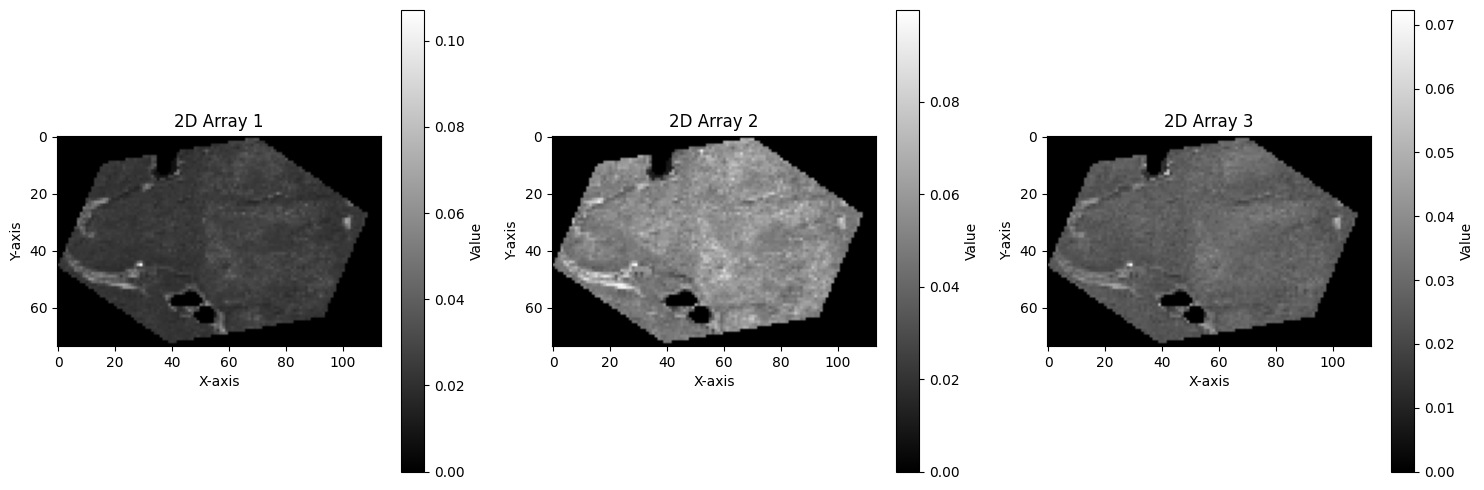

In [137]:
visualize_2d_array([np_file[0, 0], np_file[0, 1],np_file[0, 2]])

### Small model for testing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_2d_cnn_simplified(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    # x = layers.Lambda(lambda t: tf.transpose(t, perm=[0, 2, 3, 1]),
    #                   output_shape=(input_shape[1], input_shape[2], input_shape[0]))(inputs)
    #x = layers.Permute((1, 3, 2))(inputs)  # Permute to (height, width, bands)
    # x = layers.RandomFlip("horizontal_and_vertical")(x) # Temporarily remove augmentation
    # x = layers.RandomRotation(0.2)(x)
    # x = layers.RandomZoom(0.1)(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

# Assuming 'my_large_dataset.npy' is your data file
#data_files = ['../data/misc/landuse.npy', '../data/misc/soil_grid.npy', '../data/misc/worldClim.npy', '../data/misc/sat_bands.npy']
data_files = ['../data/misc/sat_bands.npy']
BATCH_SIZE = 640
y_train = create_target_species_df('ERS', processed_species)["ERS"].values
train_generator = CustomDataGenerator(
    data_file_paths=data_files,
    y_train=y_train,
    batch_size=BATCH_SIZE,
    index_subset=np.arange(0, len(y_train), 1),  # Use all indices for training
    shuffle=True
)

X_train_gen = train_generator[0][0]
y_train_gen = train_generator[0][1]

model = build_2d_cnn_simplified(input_shape=X_train_gen.shape[1:], num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(
    X_train_gen, y_train_gen,
    batch_size=32,
    epochs=10,
    verbose=1
)

Memory-mapping data file: ['../data/misc/sat_bands.npy']...
Data file memory-mapped successfully.


In [ ]:
# Assuming you have your CustomDataGenerator class defined
# ... (your CustomDataGenerator definition) ...

data_files = ['../data/misc/sat_bands.npy', '../data/misc/landuse.npy', '../data/misc/environment.npy']
BATCH_SIZE = 32
y_train = create_target_species_df('ERP', processed_species)["ERP"].values

subset_cut = int(len(y_train) * 0.2)
training_indices = np.arange(0, len(y_train) - subset_cut)
valid_indices = np.arange(len(y_train) - subset_cut, len(y_train))

train_generator = CustomDataGenerator(
    data_file_paths=data_files,
    y_train=y_train,
    batch_size=BATCH_SIZE,
    index_subset=training_indices,
    shuffle=True
)
'../data/misc/environment.npy',
validation_generator = CustomDataGenerator(
    data_file_paths=data_files,
    y_train=y_train,
    batch_size=BATCH_SIZE,
    shuffle=False,
    index_subset=valid_indices
)

# Test the training generator
print("Testing train_generator:")
try:
    for i in range(len(train_generator)):
        X_batch, y_batch = train_generator[i]
        print(f"Batch {i}: X_batch shape={X_batch.shape}, y_batch shape={y_batch.shape}")
        # Optional: Add assertions for data types, ranges, nans
        assert not np.isnan(X_batch).any(), f"NaNs found in X_batch of train_generator at index {i}"
        assert not np.isinf(X_batch).any(), f"Infs found in X_batch of train_generator at index {i}"
        assert not np.isnan(y_batch).any(), f"NaNs found in y_batch of train_generator at index {i}"
        assert not np.isinf(y_batch).any(), f"Infs found in y_batch of train_generator at index {i}"

except Exception as e:
    print(f"Error while testing train_generator: {e}")
    import traceback
    traceback.print_exc()

# Test the validation generator
print("\nTesting validation_generator:")
try:
    for i in range(len(validation_generator)):
        X_batch, y_batch = validation_generator[i]
        print(f"Batch {i}: X_batch shape={X_batch.shape}, y_batch shape={y_batch.shape}")
        assert not np.isnan(X_batch).any(), f"NaNs found in X_batch of validation_generator at index {i}"
        assert not np.isinf(X_batch).any(), f"Infs found in X_batch of validation_generator at index {i}"
        assert not np.isnan(y_batch).any(), f"NaNs found in y_batch of validation_generator at index {i}"
        assert not np.isinf(y_batch).any(), f"Infs found in y_batch of validation_generator at index {i}"
except Exception as e:
    print(f"Error while testing validation_generator: {e}")
    import traceback
    traceback.print_exc()

print("Generator testing complete.")

Data files memory-mapped successfully.
Closed memory-mapped file ../data/misc/environment.npy
Data files memory-mapped successfully.
Closed memory-mapped file ../data/misc/environment.npy
Testing train_generator:
Batch 0: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 1: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 2: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 3: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 4: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 5: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 6: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 7: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 8: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 9: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 10: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 11: X_batch shape=(32, 74, 114, 29), y_batch shape=(32,)
Batch 12: X_batch shape=(32, 74, 114, 29)

In [10]:
#load the data
extracted_bands = np.load('extracted_bands_all.npz', allow_pickle=True)
extracted_bands_satelitte = extracted_bands['satelitte']

In [125]:
extracted_bands_satelitte.shape

(4619, 5, 74, 114)

### Old model

In [11]:
import tensorflow as tf
X_train = np.moveaxis(extracted_bands_satelitte, 1, -1)#this is to make sure the format is (height, width, depth, channels)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
# Add batch dimension
#X_train = np.expand_dims(X_train, axis=0)
y_train = create_target_species_df('ERS', processed_species)["ERS"].values

In [12]:
X_train

<tf.Tensor: shape=(4619, 74, 114, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
def build_2d_cnn_simplified(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    # x = layers.Lambda(lambda t: tf.transpose(t, perm=[0, 2, 3, 1]),
    #                   output_shape=(input_shape[1], input_shape[2], input_shape[0]))(inputs)
    #x = layers.Permute((1, 3, 2))(inputs)  # Permute to (height, width, bands)
    # x = layers.RandomFlip("horizontal_and_vertical")(x) # Temporarily remove augmentation
    # x = layers.RandomRotation(0.2)(x)
    # x = layers.RandomZoom(0.1)(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [319]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_2d_cnn(input_shape, num_classes=1):
    # input_shape from generator is (total_combined_bands, x_dim, y_dim)
    # Keras layers usually expect (height, width, channels)
    # So, input_shape will be (bands, height, width)

    inputs = layers.Input(shape=input_shape) # This accepts (bands, height, width)

    # --- THE CORRECT FIX IS HERE ---
    # Transpose the input from (batch, bands, x_dim, y_dim) to (batch, x_dim, y_dim, bands)
    # Permute operates on dimensions AFTER the batch dimension.
    # Original dims (1-based): (1=bands, 2=x_dim, 3=y_dim)
    # Desired order: (x_dim, y_dim, bands) -> (2, 3, 1)
    # Data augmentation (now applied to (x, y, bands))
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomZoom(0.1)(x)
    
    # Standard 2D CNN (will now correctly receive (height, width, channels) format)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)

    x = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_last')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last')(x)
    
    # Classifier
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Binary output
    
    return models.Model(inputs, outputs)

In [1]:
# Example usage for multispectral data:
input_shape = (74, 114, 5)  # (height, width, depth (bands), channels=1 for single sample)
model = build_2d_cnn()
model.summary()

NameError: name 'build_2d_cnn' is not defined

peut-etre que le problème d'apprentissage vient de la differenece de résolution? Juste satelitte ca marche, faudrait tester en enlevant differente couches

In [283]:
#data_files = ['../data/misc/landuse.npy', '../data/misc/soil_grid.npy', '../data/misc/worldClim.npy', '../data/misc/sat_bands.npy']
data_files = ['../data/misc/sat_bands.npy']
BATCH_SIZE = 32
y_train = create_target_species_df('ERP', processed_species)["ERP"].values

subset_cut = int(len(y_train) * 0.2)
training_indices = np.arange(0, len(y_train) - subset_cut)
valid_indices = np.arange(len(y_train) - subset_cut, len(y_train))

train_generator = CustomDataGenerator(
    data_file_paths=data_files,
    y_train=y_train,
    batch_size=BATCH_SIZE,
    index_subset=training_indices,  # Use training indices for this generator
    shuffle=True
)
validation_generator = CustomDataGenerator(
    data_file_paths=data_files,
    y_train=y_train,
    batch_size=200,
    shuffle=False,
    index_subset=valid_indices  # Use validation indices for this generator
)

input_shape = train_generator[0][0][0].shape

Data files memory-mapped successfully.
Data files memory-mapped successfully.


In [284]:
input_shape

(74, 114, 5)

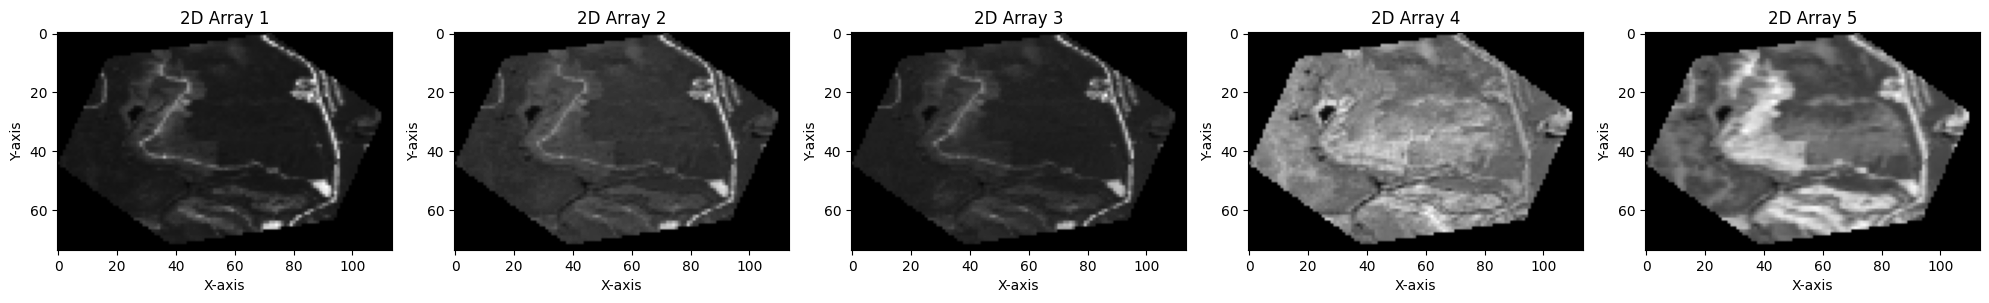

In [168]:
train = train_generator[0][0]
visualize_2d_array(train[0].transpose(2, 0, 1))
# visualize_2d_array(train)  # Visualize the first batch of the first cell

In [169]:
#input_shape =X_train[0].shape  # Adjust based on your data shape (height, width, bands)
model = build_2d_cnn(input_shape=input_shape, num_classes=1)  # Adjust input shape based on your data
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 74, 114, 5)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 74, 114, 32)    │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 37, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 37, 57, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 19, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 19, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 10, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 5, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 5, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 3, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 3, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 1, 1, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 1, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,418,785 (9.23 MB)

 Trainable params: 2,418,785 (9.23 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
print(f"Total samples: {len(y_train)}")
print(f"Training indices range: {training_indices.min()} to {training_indices.max()}")
print(f"Validation indices range: {valid_indices.min()} to {valid_indices.max()}")
print(f"Overlap between training and validation: {len(set(training_indices) & set(valid_indices))}")

validation_labels = y_train[valid_indices]
unique_labels, counts = np.unique(validation_labels, return_counts=True)
print(f"Unique labels in validation set: {unique_labels}")
print(f"Counts of labels in validation set: {counts}")

Total samples: 4619
Training indices range: 0 to 3695
Validation indices range: 3696 to 4618
Overlap between training and validation: 0
Unique labels in validation set: [0 1]
Counts of labels in validation set: [522 401]


I tried to use all the data within the same model. I upsampled the climate and soil data to match with the high resolution satelitte images, and downsampled the landuse raster but i got very poor performance(50-60% on training)... Will try with the concat method to see if having multiple model specific for resolution works better. FEATURE FUSION CNN

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6858 - loss: 0.6003 - val_accuracy: 0.6000 - val_loss: 0.6953
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7014 - loss: 0.5859 - val_accuracy: 0.5400 - val_loss: 0.7593
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7171 - loss: 0.5683 - val_accuracy: 0.6000 - val_loss: 0.7306
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7109 - loss: 0.5668 - val_accuracy: 0.5350 - val_loss: 0.7277
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7322 - loss: 0.5387 - val_accuracy: 0.5650 - val_loss: 0.7636
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7301 - loss: 0.5396 - val_accuracy: 0.5900 - val_loss: 0.7063
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7527 - loss: 0.4985 - val_accuracy: 0.6100 - val_loss: 0.6930
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.7760 - loss: 0.4935 - val_accu

Text(0.5, 1.0, 'Model accuracy')

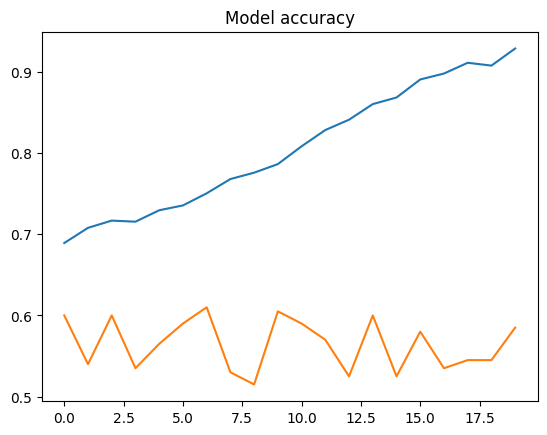

In [ ]:
valid_dataset = validation_generator
X_valid = valid_dataset[0][0]
y_valid = valid_dataset[0][1]

history = model.fit(
    train_generator,
    # x = X_train, 
    # y = y_train,
    validation_data=(X_valid, y_valid),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')


### Trying late fusion models

In [13]:
feature_importance_df = get_feature_importance_for_species('ERP', remove_landuse=True, treshold=0.01)
raster_files = fetch_raster_files(include_files=feature_importance_df['feature_name'].values)
prepare_data_with_feature_importance(feature_importance_df, with_resize=False)  # Set with_resize to False to avoid resizing

NameError: name 'get_feature_importance_for_species' is not defined

In [102]:
import numpy as np
import tensorflow as tf
import os
import math
from sklearn.model_selection import train_test_split


# --- Helper function to determine input shapes for each file ---
def get_file_input_metadata(all_file_paths):
    """
    Analyzes the file paths to determine the expected input shape (H, W, C)
    for each individual .npy file.

    Assumes .npy files are (num_cells, channels, height, width).
    """
    input_shapes_per_file = []
    
    for fpath in all_file_paths:
        # Load a small slice or just metadata (if possible) to get shape info
        temp_mmap = np.load(fpath, mmap_mode='r')
        
        # Assume (num_cells, channels, height, width)
        file_channels = temp_mmap.shape[1]
        file_height = temp_mmap.shape[2]
        file_width = temp_mmap.shape[3]
        
        input_shapes_per_file.append((file_height, file_width, file_channels))
        
        # Close the temporary mmap to free resources
        if hasattr(temp_mmap, 'base') and hasattr(temp_mmap.base, 'close'):
            temp_mmap.base.close()
        
    print("\n--- Detected File Input Metadata ---")
    for i, shape in enumerate(input_shapes_per_file):
        print(f"  File {i+1} ('{os.path.basename(all_file_paths[i])}'): Input Shape (H, W, C) = {shape}")
    print("------------------------------------\n")

    return input_shapes_per_file


# --- MultiFileInputDataGenerator Class ---
class MultiFileInputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, all_file_paths, targets, batch_size, index_subset, shuffle=True):
        """
        Initializes the data generator where each file corresponds to a separate input.

        Args:
            all_file_paths (list): List of all .npy file paths.
            targets (np.array): Array of target values corresponding to the data samples.
            batch_size (int): Number of samples per batch.
            index_subset (list or np.array): Global indices of the samples to be used by this generator.
            shuffle (bool): Whether to shuffle the data indices at the end of each epoch.
        """
        self.all_file_paths = all_file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.index_subset = np.array(index_subset)
        self.shuffle = shuffle

        # Analyze data paths to determine individual file input shapes
        self.input_shapes_per_file = get_file_input_metadata(all_file_paths)
        print(f"Input shapes per file: {self.input_shapes_per_file}")

        # Memory-map all files
        self.file_mmaps = [np.load(f, mmap_mode='r') for f in all_file_paths]
        print(f"All files memory-mapped successfully ({len(self.file_mmaps)} files).")

        self.total_samples_for_generator = len(self.index_subset)
        self.current_epoch_shuffled_cell_indices = np.copy(self.index_subset)
        self.on_epoch_end() # Call once to set up initial shuffled indices

    def __len__(self):
        return math.ceil(self.total_samples_for_generator / self.batch_size)

    # def __getitem__(self, index):
    #     start_idx_in_shuffled = index * self.batch_size
    #     end_idx_in_shuffled = min((index + 1) * self.batch_size, self.total_samples_for_generator)
    #     batch_specific_cell_indices = self.current_epoch_shuffled_cell_indices[start_idx_in_shuffled:end_idx_in_shuffled]
    #     current_batch_size = len(batch_specific_cell_indices)

    #     batch_inputs_list = [] # This will hold [batch_for_file1, batch_for_file2, ...]

    #     # Iterate through each memory-mapped file to prepare its specific batch
    #     for i, file_mmap in enumerate(self.file_mmaps):
    #         loaded_data = file_mmap[batch_specific_cell_indices]
            
    #         # Assume (num_samples, channels, height, width) from .npy files
    #         # Convert to (num_samples, height, width, channels)
    #         #if loaded_data.ndim == 4 and loaded_data.shape[1] < loaded_data.shape[2]:
    #         loaded_data = np.transpose(loaded_data, (0, 2, 3, 1))
            
    #         # Ensure the output shape matches what Keras model expects
    #         expected_h, expected_w, expected_c = self.input_shapes_per_file[i]
    #         # if loaded_data.shape[1:] != (expected_h, expected_w, expected_c):
    #         #      raise ValueError(f"Shape mismatch for input file {i} ('{os.path.basename(self.all_file_paths[i])}'). "
    #         #                       f"Expected {self.input_shapes_per_file[i]} (H, W, C) but got {loaded_data.shape[1:]}.")
            
    #         batch_inputs_list.append(loaded_data.astype(np.float32)) # Ensure float32

    #     batch_y = self.targets[batch_specific_cell_indices]
        
    #     return tuple(batch_inputs_list), batch_y

    def __getitem__(self, index):
        start_idx_in_shuffled = index * self.batch_size
        end_idx_in_shuffled = min((index + 1) * self.batch_size, self.total_samples_for_generator)
        batch_specific_cell_indices = self.current_epoch_shuffled_cell_indices[start_idx_in_shuffled:end_idx_in_shuffled]
        current_batch_size = len(batch_specific_cell_indices)

        batch_inputs_list = []     # Holds [batch_for_file1, batch_for_file2, ...]
        batch_metadata_list = []   # Holds [metadata_for_file1, metadata_for_file2, ...]

        for i, file_mmap in enumerate(self.file_mmaps):
            loaded_data = file_mmap[batch_specific_cell_indices]

            # Transpose to (batch, height, width, channels)
            loaded_data = np.transpose(loaded_data, (0, 2, 3, 1)).astype(np.float32)
            batch_inputs_list.append(loaded_data)

            # Extract individual center values and shape per sample
            center_values = []
            region_sizes = []

            for img in loaded_data:
                print(img.shape)
                h, w, channel = img.shape
                ch, cw = h // 2, w // 2
                center_value = img[ch, cw]
                center_values.append(center_value)

            center_values = np.array(center_values, dtype=np.float32)         # shape: (B, 1)
            batch_metadata_list.append(center_values)

        batch_y = self.targets[batch_specific_cell_indices]

        # Return (inputs, metadata), targets
        return (tuple(batch_inputs_list), tuple(batch_metadata_list)), batch_y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.current_epoch_shuffled_cell_indices)

    def __del__(self):
        if hasattr(self, 'file_mmaps') and isinstance(self.file_mmaps, list):
            for i, mmap_array in enumerate(self.file_mmaps):
                if hasattr(mmap_array, 'base') and hasattr(mmap_array.base, 'close'):
                    try:
                        mmap_array.base.close()
                        # print(f"Closed memory-mapped file {self.all_file_paths[i]}")
                    except Exception as e:
                        print(f"Error closing mmap for file {self.all_file_paths[i]}: {e}")



In [103]:
# 3. Instantiate the generators
BATCH_SIZE = 32
data_files = ['../data/misc/landuse.npy', '../data/misc/soil_grid.npy', '../data/misc/worldClim.npy', '../data/misc/sat_bands.npy']
#data_files = ['../data/misc/sat_bands.npy']
y_train = create_target_species_df('ERP', processed_species)["ERP"].values

subset_cut = int(len(y_train) * 0.2)
training_indices = np.arange(0, len(y_train) - subset_cut)
valid_indices = np.arange(len(y_train) - subset_cut, len(y_train))

train_generator = MultiFileInputDataGenerator(
    all_file_paths=data_files,
    targets=y_train,
    batch_size=BATCH_SIZE,
    index_subset=training_indices,
    shuffle=True
)
validation_generator = MultiFileInputDataGenerator(
    all_file_paths=data_files,
    targets=y_train,
    batch_size=BATCH_SIZE,
    index_subset=valid_indices,
    shuffle=False
)


--- Detected File Input Metadata ---
  File 1 ('landuse.npy'): Input Shape (H, W, C) = (74, 114, 1)
  File 2 ('soil_grid.npy'): Input Shape (H, W, C) = (23, 34, 6)
  File 3 ('worldClim.npy'): Input Shape (H, W, C) = (4, 5, 20)
  File 4 ('sat_bands.npy'): Input Shape (H, W, C) = (74, 114, 5)
------------------------------------

Input shapes per file: [(74, 114, 1), (23, 34, 6), (4, 5, 20), (74, 114, 5)]
All files memory-mapped successfully (4 files).

--- Detected File Input Metadata ---
  File 1 ('landuse.npy'): Input Shape (H, W, C) = (74, 114, 1)
  File 2 ('soil_grid.npy'): Input Shape (H, W, C) = (23, 34, 6)
  File 3 ('worldClim.npy'): Input Shape (H, W, C) = (4, 5, 20)
  File 4 ('sat_bands.npy'): Input Shape (H, W, C) = (74, 114, 5)
------------------------------------

Input shapes per file: [(74, 114, 1), (23, 34, 6), (4, 5, 20), (74, 114, 5)]
All files memory-mapped successfully (4 files).


In [104]:
(inputs, metadata), targets = train_generator[0]  # or any index

(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(74, 114, 1)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(23, 34, 6)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4, 5, 20)
(4

In [78]:
inputs[0].shape

(32, 74, 114, 1)

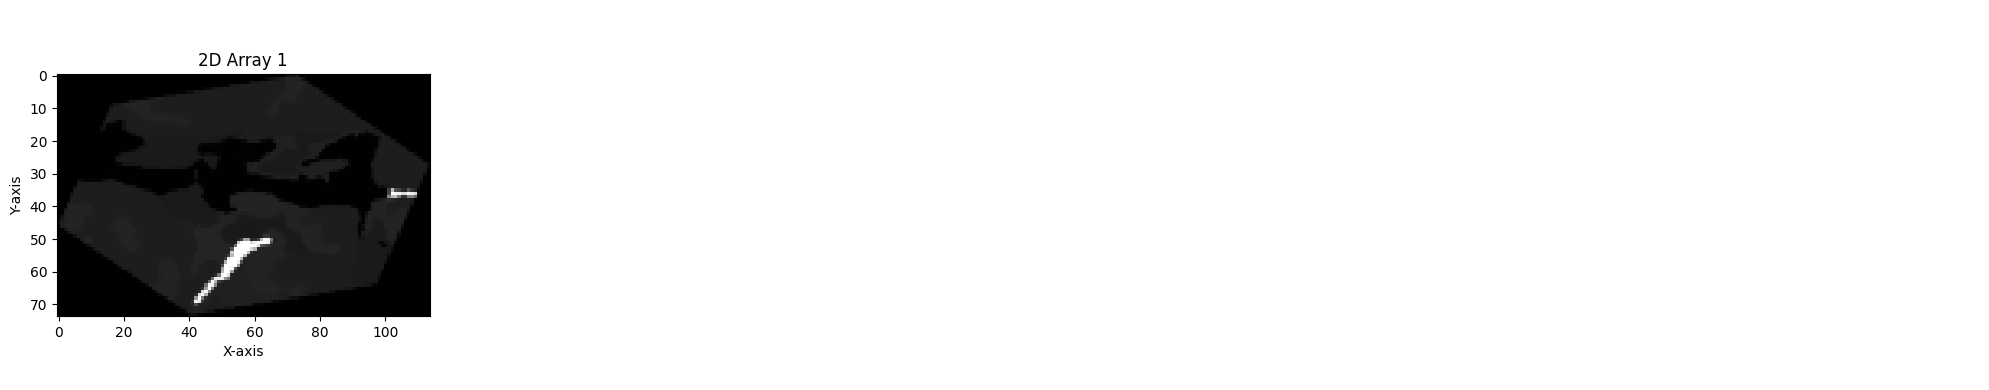

In [83]:
visualize_2d_array(inputs[0][29].transpose(2, 0, 1))

In [105]:
for i, meta in enumerate(metadata):
    print(f"Metadata for file {i}:")
    print(meta)  # shape: (batch_size, 4)
    print("--------")

Metadata for file 0:
[[0.02152615]
 [0.01886872]
 [0.02023377]
 [0.02092556]
 [0.00448622]
 [0.01834717]
 [0.08255257]
 [0.01751762]
 [0.01751762]
 [0.00773542]
 [0.01571703]
 [0.00448649]
 [0.01684622]
 [0.01776092]
 [0.01680142]
 [0.02133244]
 [0.00961388]
 [0.01556389]
 [0.01693777]
 [0.01751762]
 [0.01657146]
 [0.01739555]
 [0.0168157 ]
 [0.02011283]
 [0.07130673]
 [0.0198168 ]
 [0.01559496]
 [0.02008118]
 [0.01754612]
 [0.00791038]
 [0.01559496]
 [0.14331493]]
--------
Metadata for file 1:
[[0.0000000e+00 9.9957359e-01 0.0000000e+00 0.0000000e+00 2.3529412e-01
  0.0000000e+00]
 [3.9215689e-03 9.9957359e-01 0.0000000e+00 0.0000000e+00 2.3685122e-01
  3.9215689e-03]
 [3.9215689e-03 9.9957359e-01 3.9215689e-03 0.0000000e+00 2.0392157e-01
  0.0000000e+00]
 [0.0000000e+00 9.9954313e-01 0.0000000e+00 0.0000000e+00 1.9607843e-01
  3.9215689e-03]
 [0.0000000e+00 9.9981725e-01 7.8431377e-03 0.0000000e+00 1.9607844e-02
  2.5490196e-02]
 [0.0000000e+00 9.9946702e-01 0.0000000e+00 0.0000000e+

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, RandomFlip, RandomRotation, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers # Import layers explicitly for Activation

def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1), activation='relu'):
    """
    A basic residual block consisting of two convolutional layers with Batch Normalization
    and a shortcut connection.

    Args:
        x: Input tensor to the residual block.
        filters: Number of filters for the convolutional layers within the block.
        kernel_size: Kernel size for the convolutional layers (default: 3x3).
        stride: Stride for the first convolutional layer (default: 1x1).
                Used for downsampling within the block if needed.
        activation: Activation function to use after each convolution and after the final addition.

    Returns:
        tf.Tensor: Output tensor of the residual block.
    """
    # Store the input for the shortcut connection
    shortcut = x

    # Main path: First convolutional layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = layers.Activation(activation)(x) # Use layers.Activation for clarity

    # Main path: Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Shortcut connection:
    # If the spatial dimensions change (due to stride) OR
    # if the number of filters changes, apply a 1x1 convolution to the shortcut.
    # This aligns the dimensions so it can be added to the main path's output.
    current_filters_in_shortcut = shortcut.shape[-1]
    if stride != (1, 1) or current_filters_in_shortcut != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same',
                                 kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut connection to the main path output
    x = layers.add([x, shortcut])
    # Apply final activation after the addition
    x = layers.Activation(activation)(x)
    return x

def build_dynamic_multi_file_input_model(input_shapes_per_file, output_dim=1, activation='linear'):
    """
    Builds a Keras model with a separate CNN branch for each input file.
    The branch becomes deeper with residual blocks if the input height (input_shape[0]) is > 70.

    Args:
        input_shapes_per_file (list): A list of (H, W, C) input shapes, one for each file.
                                      Order must match the generator's file order.
        output_dim (int): Dimension of the final output.
        activation (str): Activation function for the final output layer.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    input_layers = []
    feature_vectors = []

    for i, input_shape in enumerate(input_shapes_per_file):
        # Input layer expects (height, width, channels)
        input_layer = Input(shape=input_shape, name=f'file_input_{i:02d}')
        input_layers.append(input_layer)

        # Data augmentation (applied *after* the Input layer)
        # These layers are applied per branch for flexibility.
        x = input_layer # Start with the raw input for this branch
        #x = RandomFlip("horizontal_and_vertical")(x)
        x = RandomRotation(0.2)(x)
        
        # --- Base CNN layers (common for all resolutions) ---
        # These initial layers set up the features before potential deeper processing.
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Output H/2, W/2

        x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Output H/4, W/4

        x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Output H/8, W/8
        
        # --- Conditional Deeper Layers with Residual Blocks ---
        if input_shape[0] > 70: # If the original height is greater than 70 pixels
            print(f"Adding deeper layers with Residual Blocks for input_shape: {input_shape}")
            
            # Replaced Conv2D(64, ...) with residual_block(filters=64)
            # x has 64 filters from the previous MaxPooling2D output
            x = residual_block(x, filters=64)
            x = MaxPooling2D(pool_size=(2, 2), padding='same')(x) # Output H/16, W/16

            # Replaced Conv2D(128, ...) with residual_block(filters=128)
            # Shortcut needs to handle filter count change from 64 to 128
            x = residual_block(x, filters=128)
            x = MaxPooling2D(pool_size=(2, 2), padding='same', name=f'pool_extra1_{i}')(x) # Output H/32, W/32

            # Replaced Conv2D(256, ...) with residual_block(filters=256)
            # Shortcut needs to handle filter count change from 128 to 256
            x = residual_block(x, filters=256)
            x = MaxPooling2D(pool_size=(2, 2), padding='same', name=f'pool_extra3_{i}')(x) # Output H/128, W/128

            # Replaced Conv2D(512, ...) with residual_block(filters=512)
            # Shortcut needs to handle filter count change from 256 to 512
            x = residual_block(x, filters=512)
            x = MaxPooling2D(pool_size=(2, 2), padding='same', name=f'pool_extra5_{i}')(x) # Output H/512, W/512
        else:
            print(f"Using standard layers for input_shape: {input_shape}")

        # Flatten the output of this branch into a feature vector
        x = Flatten(name=f'flatten_file_{i:02d}')(x)
        feature_vectors.append(x)

    # Concatenate all feature vectors from different branches
    if len(feature_vectors) > 1:
        merged_features = concatenate(feature_vectors, name='concatenated_features')
    else: # If there's only one input file, no concatenation is needed
        merged_features = feature_vectors[0]

    # Add final dense layers for fusion and prediction
    # Batch Normalization is crucial here for stabilizing training
    x = Dense(128, activation='relu')(merged_features)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Added Dropout for regularization

    # Final output layer
    output = Dense(output_dim, activation=activation, name='output_prediction')(x)

    # Create the Keras model with specified inputs and outputs
    model = Model(inputs=input_layers, outputs=output)
    return model


In [20]:
model = build_dynamic_multi_file_input_model(
    input_shapes_per_file=train_generator.input_shapes_per_file,
    output_dim=1,  # Binary classification
    activation='sigmoid'  # Sigmoid for binary classification
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
model.summary()

Adding deeper layers with Residual Blocks for input_shape: (74, 114, 1)
Using standard layers for input_shape: (23, 34, 6)
Using standard layers for input_shape: (4, 5, 20)
Adding deeper layers with Residual Blocks for input_shape: (74, 114, 5)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ file_input_00       │ (None, 74, 114,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ file_input_03       │ (None, 74, 114,   │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 114,   │        320 │ file_input_00[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 74, 114,   │      1,472 │ file_input_03[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 37, 57,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 37, 57,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 37, 57,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 37, 57,    │      9,248 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 19, 29,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 19, 29,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 19, 29,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 19, 29,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 15,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 10, 15,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 15,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 10, 15,    │     36,928 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 15,    │        256 │ conv2d_3[0][0]  

 Total params: 10,956,929 (41.80 MB)

 Trainable params: 10,941,313 (41.74 MB)

 Non-trainable params: 15,616 (61.00 KB)

In [366]:
!wandb login --relogin d5ba85cf74af80fc68c7682714ed59091a739349

wandb: Appending key for api.wandb.ai to your netrc file: /home/alexis/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [25]:
model = build_dynamic_multi_file_input_model(
    input_shapes_per_file=train_generator.input_shapes_per_file,
    output_dim=1,  # Binary classification
    activation='sigmoid'  # Sigmoid for binary classification
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


train_generator = MultiFileInputDataGenerator(
    all_file_paths=data_files,
    targets=y_train,
    batch_size=BATCH_SIZE,
    index_subset=training_indices,
    shuffle=True
)
validation_generator = MultiFileInputDataGenerator(
    all_file_paths=data_files,
    targets=y_train,
    batch_size=BATCH_SIZE,
    index_subset=valid_indices,
    shuffle=False
)

Adding deeper layers with Residual Blocks for input_shape: (74, 114, 1)
Using standard layers for input_shape: (23, 34, 6)
Using standard layers for input_shape: (4, 5, 20)
Adding deeper layers with Residual Blocks for input_shape: (74, 114, 5)

--- Detected File Input Metadata ---
  File 1 ('landuse.npy'): Input Shape (H, W, C) = (74, 114, 1)
  File 2 ('soil_grid.npy'): Input Shape (H, W, C) = (23, 34, 6)
  File 3 ('worldClim.npy'): Input Shape (H, W, C) = (4, 5, 20)
  File 4 ('sat_bands.npy'): Input Shape (H, W, C) = (74, 114, 5)
------------------------------------

Input shapes per file: [(74, 114, 1), (23, 34, 6), (4, 5, 20), (74, 114, 5)]
All files memory-mapped successfully (4 files).

--- Detected File Input Metadata ---
  File 1 ('landuse.npy'): Input Shape (H, W, C) = (74, 114, 1)
  File 2 ('soil_grid.npy'): Input Shape (H, W, C) = (23, 34, 6)
  File 3 ('worldClim.npy'): Input Shape (H, W, C) = (4, 5, 20)
  File 4 ('sat_bands.npy'): Input Shape (H, W, C) = (74, 114, 5)
------

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping callback
# Monitors 'val_loss' (or 'val_accuracy'), stops if no improvement for 'patience' epochs.
# 'restore_best_weights' ensures you get the model weights from the best performing epoch.
early_stopping = EarlyStopping(
    monitor='val_loss', # You can also use 'val_accuracy'
    patience=10,         # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True,
    verbose=1
)

# Define ReduceLROnPlateau callback
# Reduces learning rate when 'val_loss' has stopped improving.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', # You can also use 'val_accuracy'
    factor=0.5,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-6,        # Lower bound on the learning rate.
    verbose=1
)

# When compiling your model, make sure you're using an optimizer
# For example, Adam is a good general-purpose optimizer
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Adjust loss based on output_dim and activation

# Then, when you train your model:
# model.fit(
#     your_training_data,
#     your_training_labels,
#     epochs=300, # Or a large number, EarlyStopping will stop it
#     validation_data=(your_validation_data, your_validation_labels),
#     callbacks=[early_stopping, lr_scheduler] # Pass the callbacks here
# )

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 167ms/step - accuracy: 0.5662 - loss: 0.9479 - val_accuracy: 0.5016 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.6267 - loss: 0.7457 - val_accuracy: 0.5655 - val_loss: 1.0654 - learning_rate: 0.0010
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6851 - loss: 0.6240 - val_accuracy: 0.5092 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.7000 - loss: 0.5873 - val_accuracy: 0.5655 - val_loss: 1.1307 - learning_rate: 0.0010
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 0.7320 - loss: 0.5450 - val_accuracy: 0.5688 - val_loss: 1.1629 - learning_rate: 0.0010
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7332 - loss: 0.5554
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
116/116 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.733

Text(0.5, 1.0, 'Model accuracy')

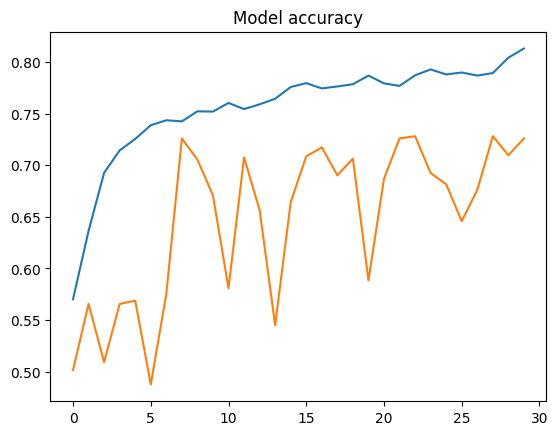

In [26]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30, # Adjust as needed
    verbose=1,
    #callbacks=[early_stopping, lr_scheduler]  # Pass the callbacks here
)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

In [310]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

KeyError: 'accuracy'